# Introduction

In this project, we use supervised learning models to identify customers who are likely to churn in the future. We also analyze top factors that influence user exited.

How do we define "churn"?
Definition: existing users that close their bank accounts

Why do they churn?
In this case, we analyzed many factors how the users that close their bank accounts.

## Metadata

This dataset is for ABC Multistate bank with following columns:
* RowNumber—corresponds to the record (row) number and has no effect on the output.
* CustomerId—contains random values and has no effect on customer leaving the bank.
* Surname—the surname of a customer has no impact on their decision to leave the bank.
* CreditScore—can have an effect on customer churn, since a customer with a higher credit score is less likely to leave the bank.
* Geography—a customer’s location can affect their decision to leave the bank.
* Gender—it’s interesting to explore whether gender plays a role in a customer leaving the bank.
* Age—this is certainly relevant, since older customers are less likely to leave their bank than younger ones.
* Tenure—refers to the number of years that the customer has been a client of the bank. Normally, older clients are more loyal and less likely to leave a bank.
* Balance—also a very good indicator of customer churn, as people with a higher balance in their accounts are less likely to leave the bank compared to those with lower balances.
* NumOfProducts—refers to the number of products that a customer has purchased through the bank.
* HasCrCard—denotes whether or not a customer has a credit card. This column is also relevant, since people with a credit card are less likely to leave the bank.
* IsActiveMember—active customers are less likely to leave the bank.
EstimatedSalary—as with balance, people with lower salaries are more likely to leave the bank compared to those with higher salaries.
* Exited—whether or not the customer left the bank.



# Import Libraries

In [ ]:
!pip install skope-rules
!pip install eli5
!pip install scikit-plot
!pip install shap
!pip install lime
!pip install dalex
!pip install feature-engine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 31.6 MB/s 
     |████████████████████████████████| 133 kB 45.4 MB/s 
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=747dca1ff3e7f9d3d1eb4bf3d9a8597caa4d6797e88a1f6b2e5950cfa8b7bcc1
  Stored in directory: /root/.cache/pip/wheels/cc/3c/96/3ead31a8e6c20fc0f1a707fde2e05d49a80b1b4b30096573be
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.1.2 which

In [ ]:
import pandas as pd
pd.set_option("display.max_columns",None)

import numpy as np
import seaborn as sns
sns.set(style='whitegrid')
sns.set_palette("bright")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
palette = {0: 'tab:blue',1: 'tab:orange'}

import plotly.express as px
import pickle
from scipy import stats
from scipy.stats import chi2_contingency

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import *
from sklearn.feature_selection import RFECV
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV, cross_val_score
import sklearn.metrics as metrics

from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, cross_validate, StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import *
from sklearn import svm,tree
from sklearn import ensemble
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay
from sklearn import model_selection

# load rulefit model
import six
import sys
sys.modules['sklearn.externals.six'] = six
from skrules import SkopeRules

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from yellowbrick.classifier import DiscriminationThreshold 

# load scikit-plot modules
import scikitplot as skplt

# load shap package for shap explanation
import shap

# load eli5
import eli5

# load LimeTabularExplainer for LIME method
from lime.lime_tabular import LimeTabularExplainer 

# import dalex to explain complex model
import dalex as dx

# for Q-Q plots
import scipy.stats as stats
from feature_engine.outliers import Winsorizer
from scipy.stats import chi2_contingency

import os, random
import tensorflow as tf
from tensorflow import keras

import warnings
warnings.filterwarnings('ignore')

# Data Inspection

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset/Bank Customer Churn Prediction.csv')

In [ ]:
data

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [ ]:
columns_name =[]
unique_value=[]
# Iterate through the columns
for col in data:
    if data[col].dtype == 'object':
        # If 2 or fewer unique categories
        columns_name.append(str(col)) 
        unique_value.append(data[col].nunique())
table= pd.DataFrame()
table['Columns'] = columns_name
table['Unique']= unique_value
            
table=table.sort_values('Unique',ascending=False)
table

,Columns,Unique
0,Surname,2932
1,Geography,3
2,Gender,2


In [ ]:
# extracting categorical columns
cat = data.select_dtypes(include = ['object'])

# printing unique values of each column
for col in cat.columns:
    print(f"{col}: \n{cat[col].unique()}\n")

Surname: 
['Hargrave' 'Hill' 'Onio' ... 'Kashiwagi' 'Aldridge' 'Burbidge']

Geography: 
['France' 'Spain' 'Germany']

Gender: 
['Female' 'Male']



# Data Preparation

### Missing Values Handling

In [ ]:
data.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [ ]:
# Data Profilling
print("="*10,"Data Profilling","="*10)

# Data Shape
print("Data shape :", data.shape)
print("")

# Data Info
print("Data info :")
print(data.info())
print("")

# Data duplication
print("Data duplication :")
print(data.duplicated().sum())
print("")

========== Data Profilling ==========
Data shape : (10000, 14)

Data info :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB
None

Data duplica

## Droping The Unused Data

In [ ]:
data = data.drop(['CustomerId','RowNumber','Surname'], axis=1)

In [ ]:
data

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [ ]:
# extracting categorical columns
cat = data.select_dtypes(include = ['object'])

# printing unique values of each column
for col in cat.columns:
    print(f"{col}: \n{cat[col].unique()}\n")

Geography: 
['France' 'Spain' 'Germany']

Gender: 
['Female' 'Male']



##  Data Correlation

In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
Age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
Tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
Balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
NumOfProducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00
HasCrCard,10000.0,0.705500,0.455840,0.00,0.00,1.000,1.0000,1.00
IsActiveMember,10000.0,0.515100,0.499797,0.00,0.00,1.000,1.0000,1.00
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48
Exited,10000.0,0.203700,0.402769,0.00,0.00,0.000,0.0000,1.00


### Correlation Between Quantitative Variables

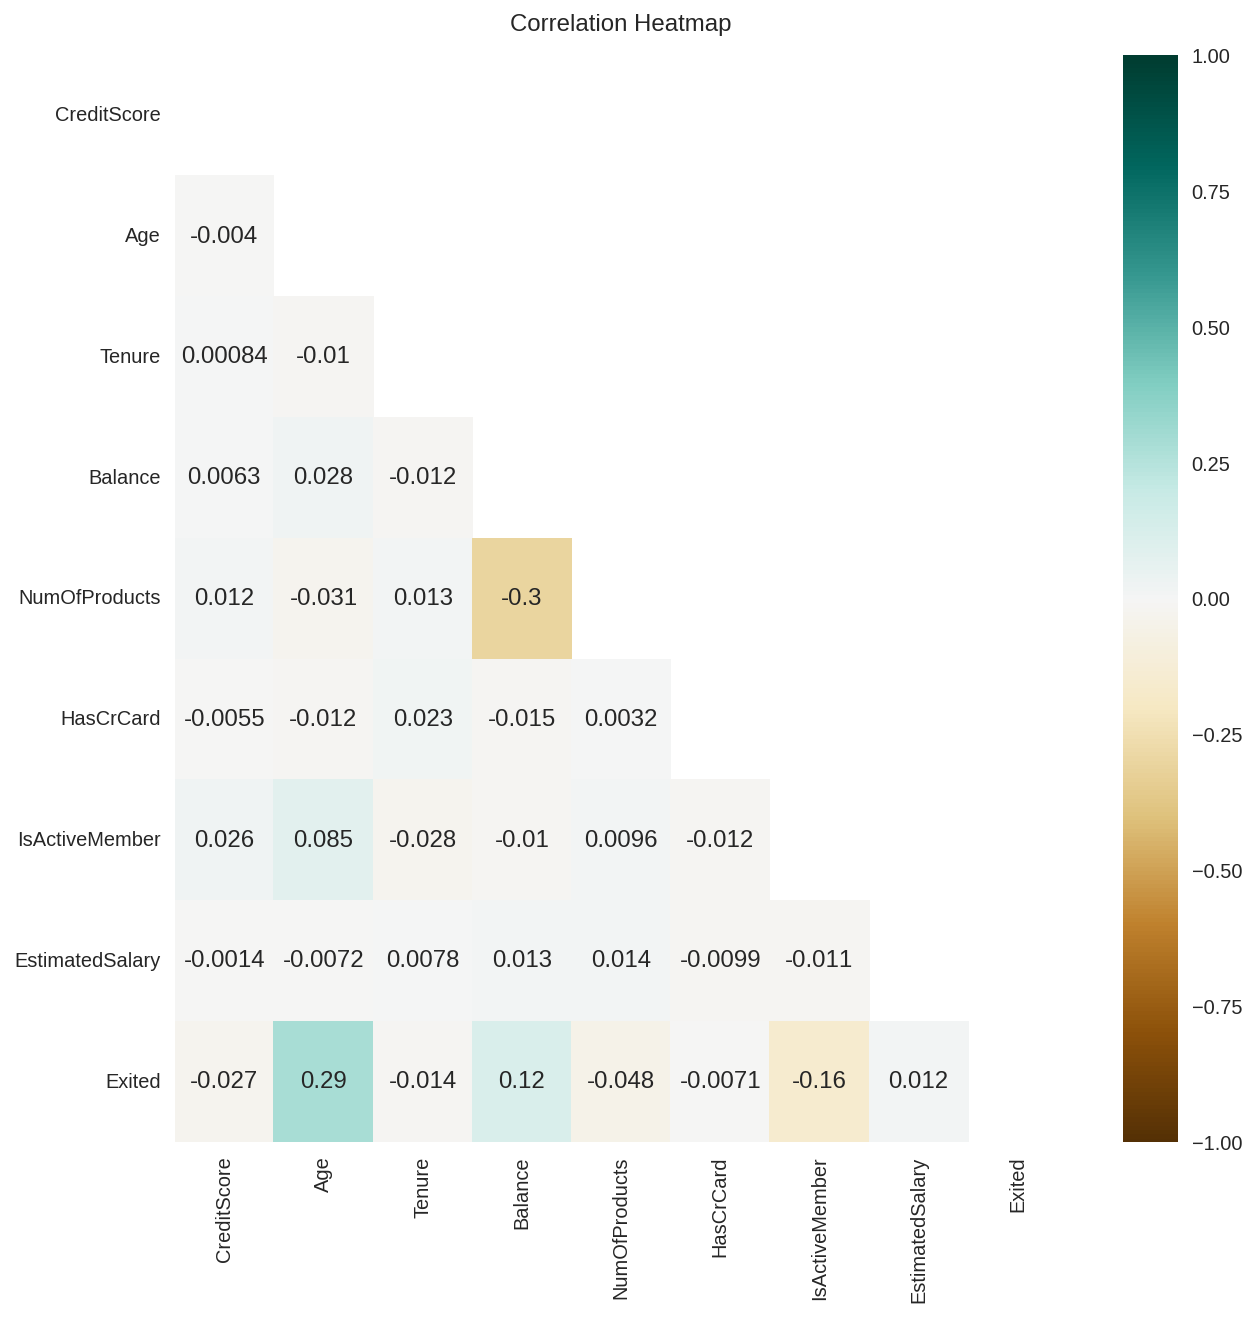

In [ ]:
# Increase the size of the heatmap
plt.figure(figsize=(10,10))

# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap
mask = np.triu(np.ones_like(data.corr(), dtype=np.bool))
heatmap = sns.heatmap(data.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')

# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

### Correlation Between Qualitative Variables

In [ ]:
def cramers_corrected_stat(contingency_table):
    """
        Computes corrected Cramer's V statistic for categorial-categorial association
    """
    
    try:
        chi2 = chi2_contingency(contingency_table)[0]
    except ValueError:
        return np.NaN
    
    n = contingency_table.sum().sum()
    phi2 = chi2/n
    
    r, k = contingency_table.shape
    r_corrected = r - (((r-1)**2)/(n-1))
    k_corrected = k - (((k-1)**2)/(n-1))
    phi2_corrected = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    
    return (phi2_corrected / min( (k_corrected-1), (r_corrected-1)))**0.5

In [ ]:
def categorical_corr_matrix(data):
    """
        Computes corrected Cramer's V statistic between all the
        categorical variables in the dataframe
    """
    data = data.select_dtypes(include='object')
    cols = data.columns
    n = len(cols)
    corr_matrix = pd.DataFrame(np.zeros(shape=(n, n)), index=cols, columns=cols)
    
    excluded_cols = list()
    
    for col1 in cols:
        for col2 in cols:
            if col1 == col2:
                corr_matrix.loc[col1, col2] = 1
                break
            data_crosstab = pd.crosstab(data[col1], data[col2], dropna=False)
            corr_matrix.loc[col1, col2] = cramers_corrected_stat(data_crosstab)
                
    # Flip and add to get full correlation matrix
    corr_matrix += np.tril(corr_matrix, k=-1).T
    return corr_matrix

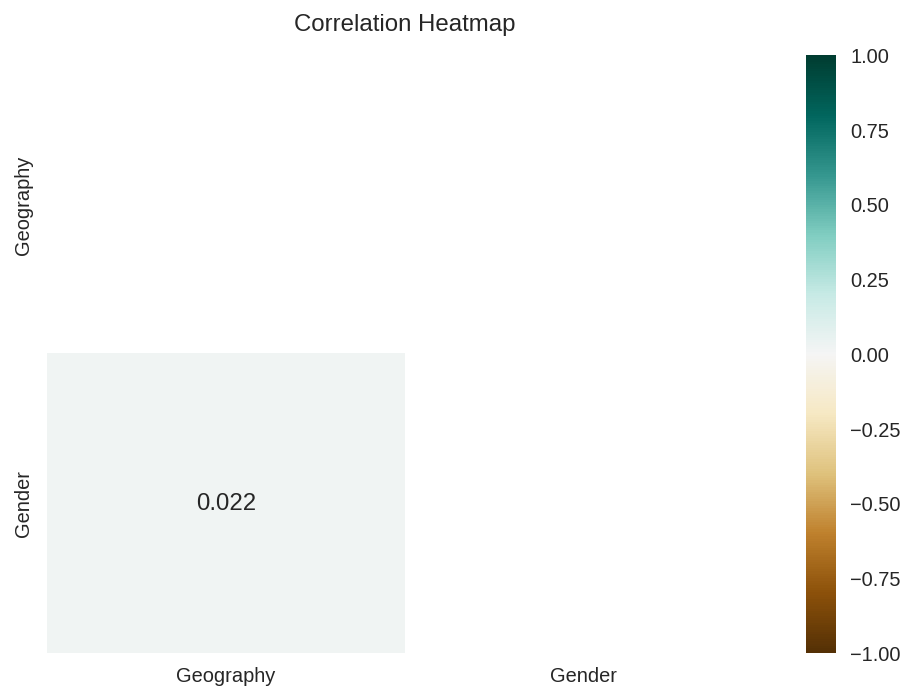

In [ ]:
# Increase the size of the heatmap
plt.figure()

# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap
mask = np.triu(np.ones_like(categorical_corr_matrix(data), dtype=np.bool))
heatmap = sns.heatmap(categorical_corr_matrix(data), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')

# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

# Exploratory Data Analysis

## Frequency Distribution: Categorical Variables

In [ ]:
churn = data['Exited'].value_counts()

fig = px.pie(churn, 
             values = churn.values, 
             names = churn.index)
fig.update_traces(textposition='inside', textinfo='percent+label+value', 
                  marker = dict(line = dict(color = 'white', width = 2)))
fig.show(figsize=(3,3))

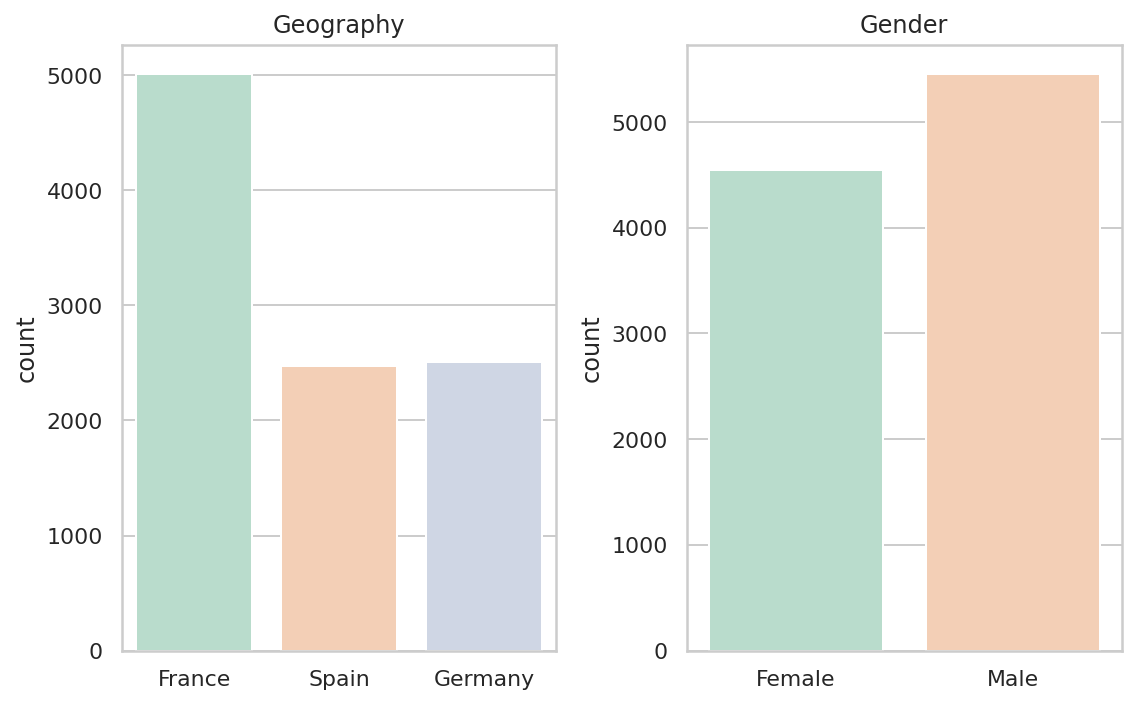

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))
titles = list(data.select_dtypes(include=['object']))

ax_title_pairs = zip(axs.flat, titles)

for ax, title in ax_title_pairs:
    sns.countplot(x=title, data=data, palette='Pastel2', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('')

plt.tight_layout()

## Frequency Distribution: Categorical Variables by Churn

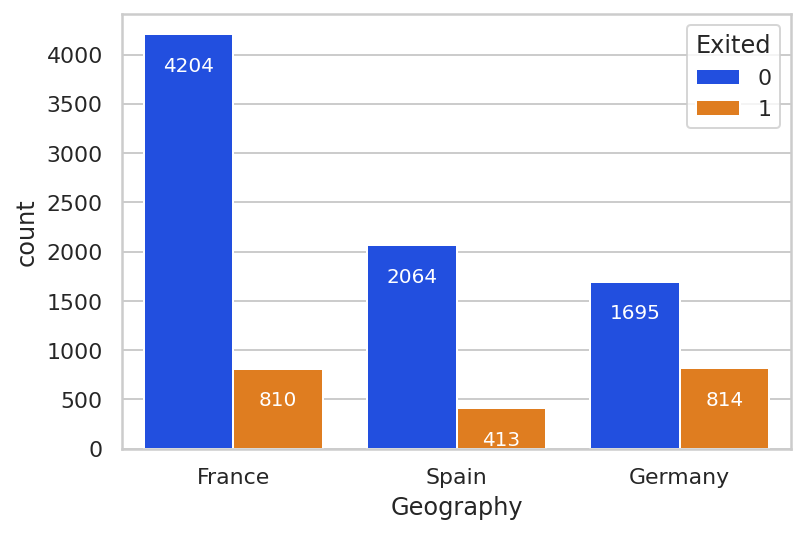

In [ ]:
ax = sns.countplot(x="Geography", hue="Exited", data=data)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='center', va='top', color='white', size=10)

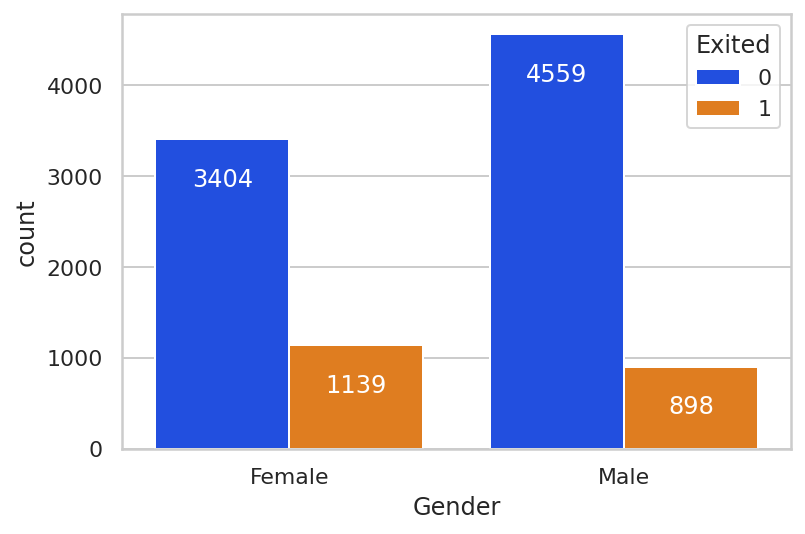

In [ ]:
ax = sns.countplot(x="Gender", hue="Exited", data=data)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='center', va='top', color='white', size=12)

## Frequency Distribution: Continuous Variables

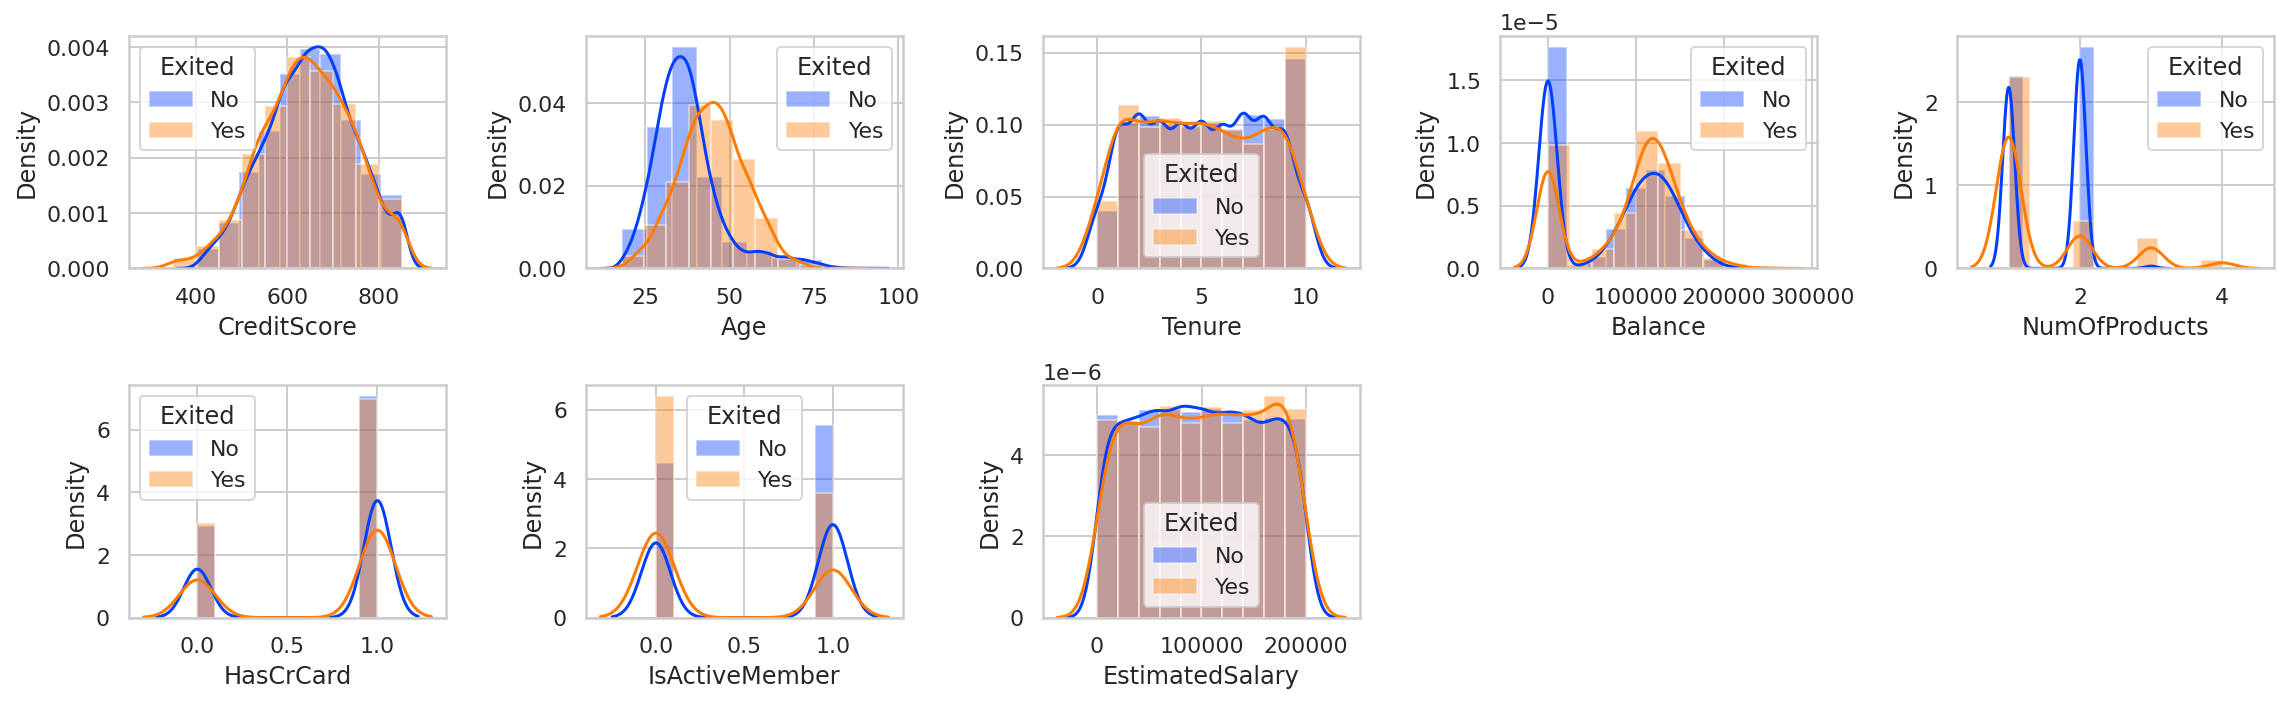

In [ ]:
data_grouped = data.groupby(by='Exited')
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(16,5))
titles = list(data.select_dtypes(exclude=['object']))

ax_title_pairs = zip(axs.flat, titles)

for ax, title in ax_title_pairs:
    sns.distplot(data_grouped.get_group(0)[title], bins=10, ax=ax,label='No')
    sns.distplot(data_grouped.get_group(1)[title], bins=10, ax=ax,label='Yes')
    ax.legend(title='Exited')

axs.flat[-1].remove()
axs.flat[-2].remove()
fig.tight_layout()

## Box Plots : Outlier Detection

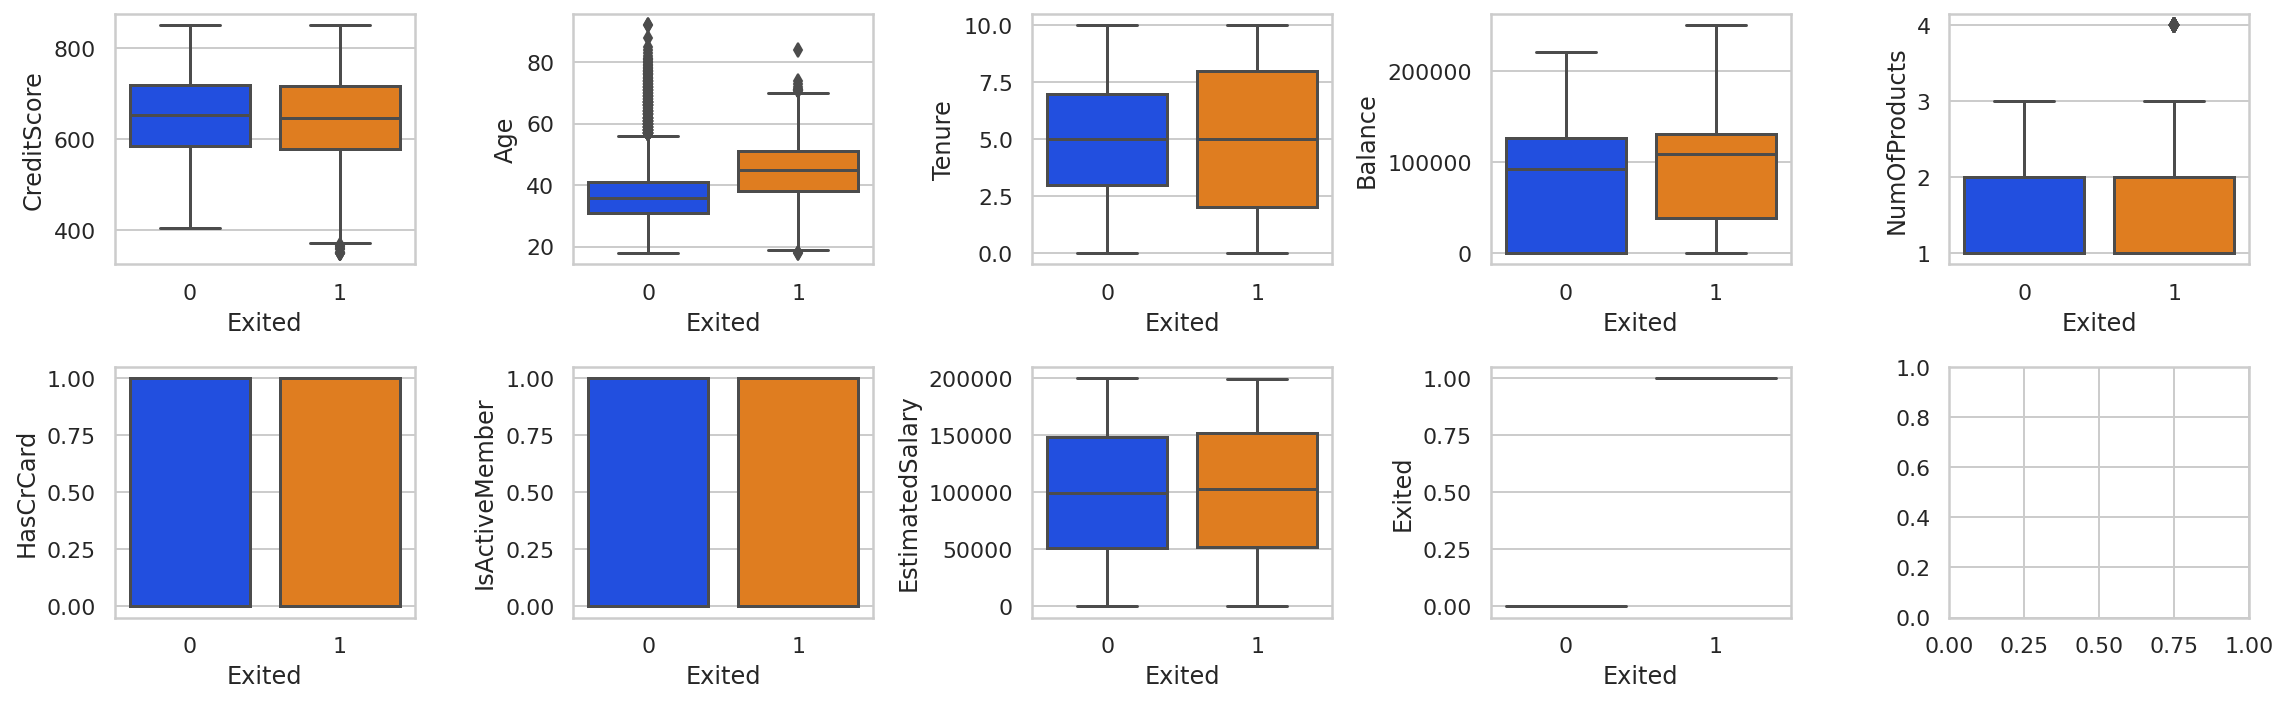

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(16,5))
titles = data.select_dtypes(exclude=['object'])
ax_title_pairs = zip(axs.flat, titles)
for ax, title in ax_title_pairs:
    sns.boxplot(x='Exited', y=title, data=data, ax=ax)
fig.tight_layout()

# Data Pre-Processing

## Data Encoding

In [ ]:
# Columns Encoding
data['Geography'] = data['Geography'].replace({'France': 1,'Germany': 0, 'Spain': 2})
data['Gender'] = data['Gender'].replace({'Male': 1, 'Female': 0})

In [ ]:
data

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,1,0,42,2,0.00,1,1,1,101348.88,1
1,608,2,0,41,1,83807.86,1,0,1,112542.58,0
2,502,1,0,42,8,159660.80,3,1,0,113931.57,1
3,699,1,0,39,1,0.00,2,0,0,93826.63,0
4,850,2,0,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,1,1,39,5,0.00,2,1,0,96270.64,0
9996,516,1,1,35,10,57369.61,1,1,1,101699.77,0
9997,709,1,0,36,7,0.00,1,0,1,42085.58,1
9998,772,0,1,42,3,75075.31,2,1,0,92888.52,1


## Resampling

In [ ]:
# Assign 'TARGET' column to y 
y = data['Exited'].values
# Assign all columns except 'TARGET' to X
X = data.drop(['Exited'], axis = 1).values

In [ ]:
# Check dimension
print('X shape :', X.shape)
print('y shape :', y.shape)

X shape : (10000, 10)
y shape : (10000,)


In [ ]:
# split data to train and test data
# with test size is 20% of overall data
# use stratified sampling
# and set RNG to 1000
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.2,
    stratify = y,
    random_state = 42
)

In [ ]:
# Make a new dataframe using train & test data
train_data_x = pd.DataFrame(X_train, columns=data.drop(['Exited'], axis = 1).columns)
train_data_y = pd.DataFrame(y_train, columns=['Exited'])
train_data = pd.concat([train_data_x, train_data_y], axis=1)

test_data_x = pd.DataFrame(X_test, columns=data.drop(['Exited'], axis = 1).columns)
test_data_y = pd.DataFrame(y_test, columns=['Exited'])
test_data = pd.concat([test_data_x, test_data_y], axis=1)

In [ ]:
train_data

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,753.0,1.0,1.0,57.0,7.0,0.00,1.0,1.0,0.0,159475.08,1
1,739.0,0.0,1.0,32.0,3.0,102128.27,1.0,1.0,0.0,63981.37,1
2,755.0,0.0,0.0,37.0,0.0,113865.23,2.0,1.0,1.0,117396.25,0
3,561.0,1.0,1.0,37.0,5.0,0.00,2.0,1.0,0.0,83093.25,0
4,692.0,0.0,1.0,49.0,6.0,110540.43,2.0,0.0,1.0,107472.99,0
...,...,...,...,...,...,...,...,...,...,...,...
7995,688.0,2.0,0.0,35.0,6.0,0.00,1.0,1.0,0.0,25488.43,1
7996,712.0,2.0,1.0,74.0,5.0,0.00,2.0,0.0,0.0,151425.82,0
7997,667.0,1.0,0.0,37.0,9.0,71786.90,2.0,1.0,1.0,67734.79,0
7998,687.0,2.0,1.0,35.0,8.0,100988.39,2.0,1.0,0.0,22247.27,0


In [ ]:
test_data

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,585.0,1.0,1.0,36.0,7.0,0.00,2.0,1.0,0.0,94283.09,0
1,525.0,0.0,1.0,33.0,4.0,131023.76,2.0,0.0,0.0,55072.93,0
2,557.0,2.0,0.0,40.0,4.0,0.00,2.0,0.0,1.0,105433.53,0
3,639.0,2.0,1.0,34.0,5.0,139393.19,2.0,0.0,0.0,33950.08,0
4,640.0,2.0,0.0,34.0,3.0,77826.80,1.0,1.0,1.0,168544.85,0
...,...,...,...,...,...,...,...,...,...,...,...
1995,674.0,1.0,1.0,36.0,2.0,154525.70,1.0,0.0,1.0,27468.72,0
1996,634.0,0.0,1.0,37.0,3.0,111432.77,2.0,1.0,1.0,167032.49,0
1997,516.0,0.0,0.0,47.0,9.0,128298.74,1.0,0.0,0.0,149614.17,1
1998,689.0,1.0,1.0,39.0,7.0,0.00,2.0,0.0,0.0,14917.09,0


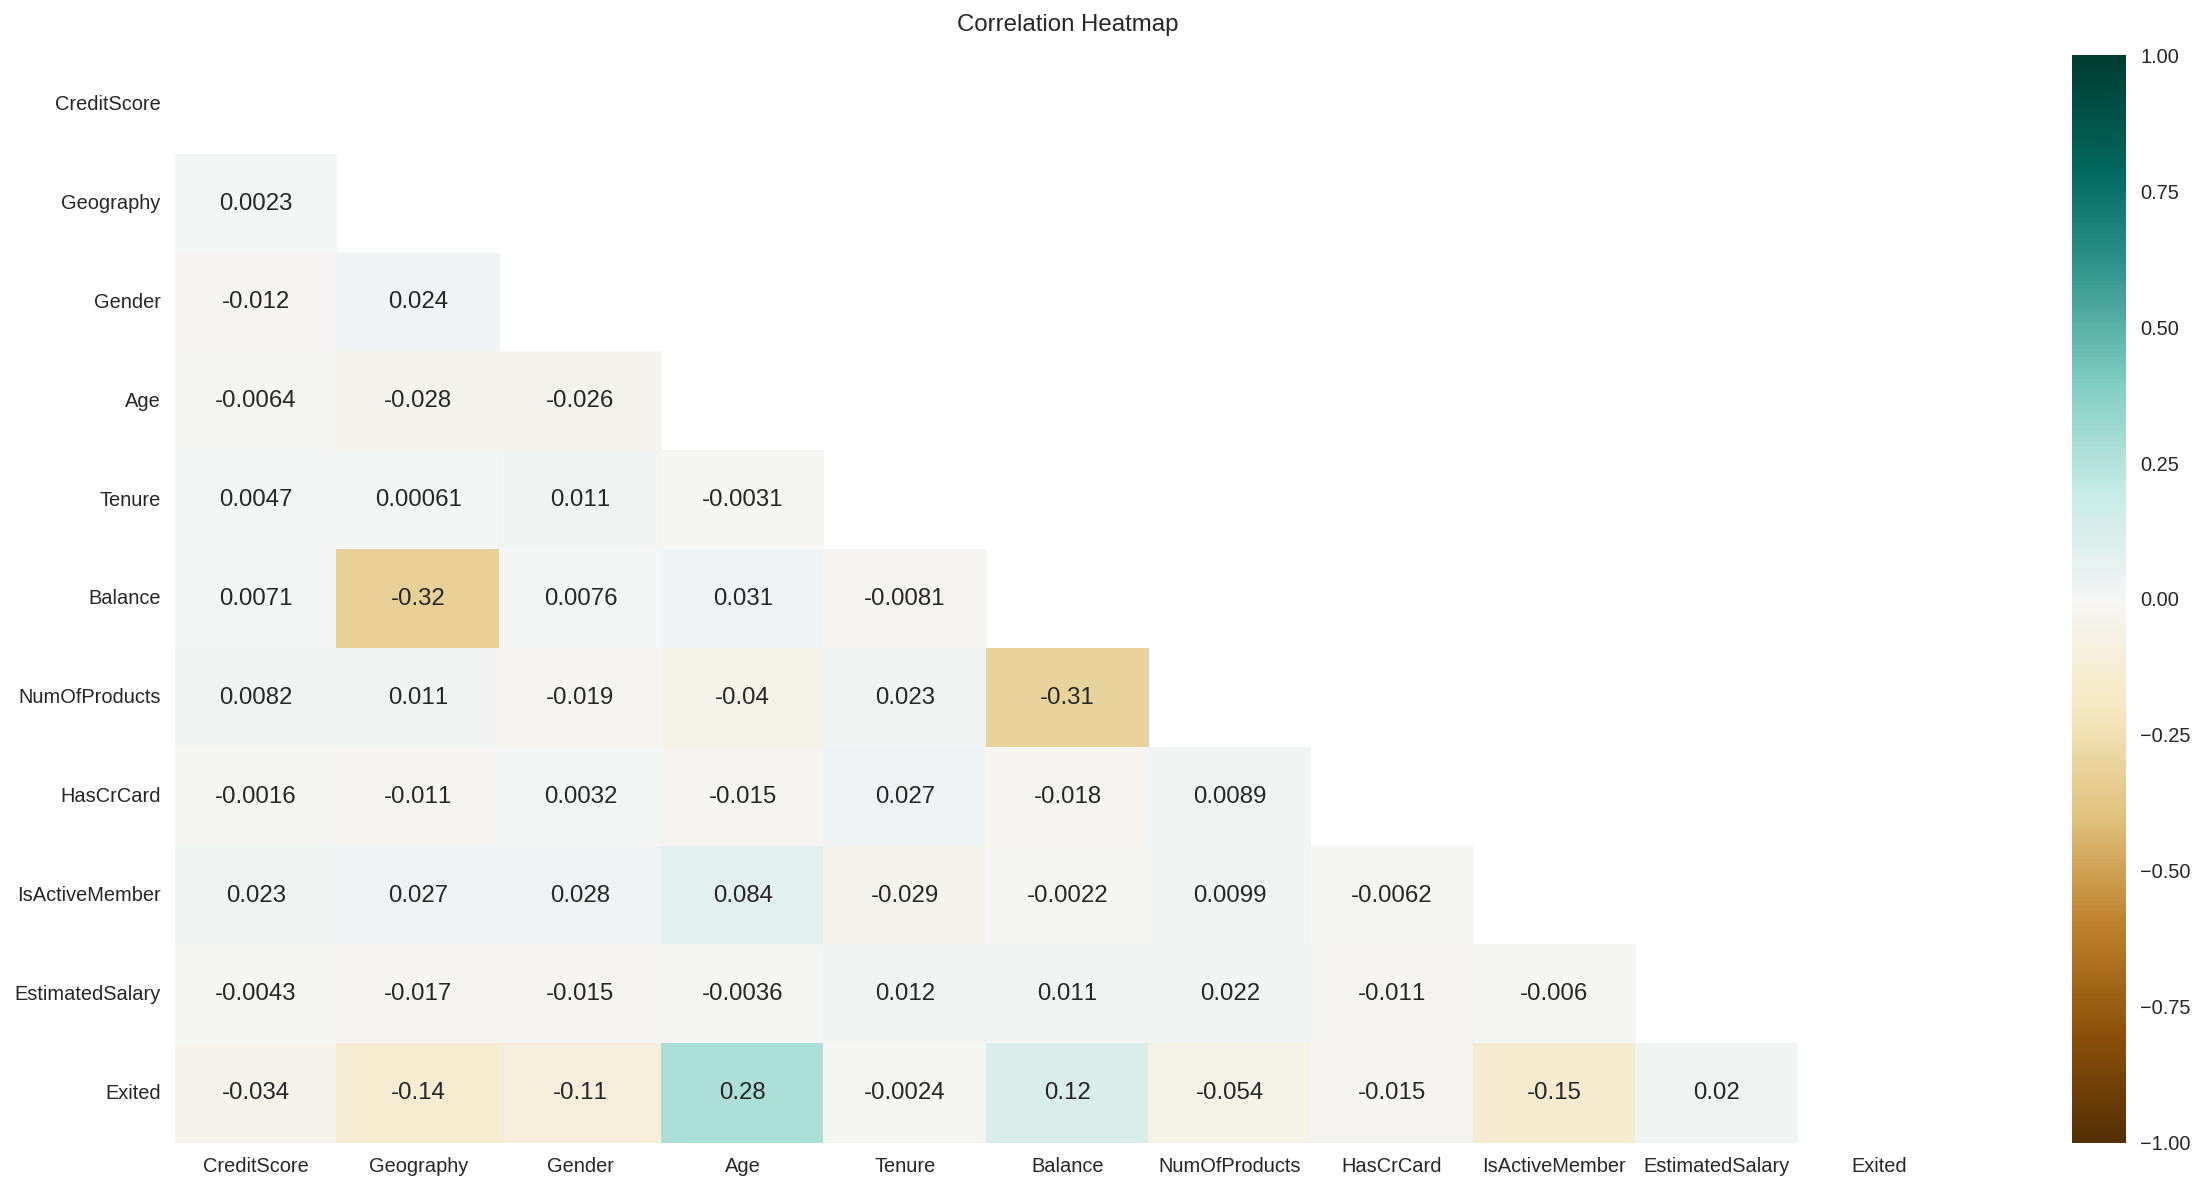

In [ ]:
# Increase the size of the heatmap
plt.figure(figsize=(20,10))

# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap
mask = np.triu(np.ones_like(train_data.corr(), dtype=np.bool))
heatmap = sns.heatmap(train_data.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')

# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

## Normalization

In [ ]:
# Check train data
train_data

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,753.0,1.0,1.0,57.0,7.0,0.00,1.0,1.0,0.0,159475.08,1
1,739.0,0.0,1.0,32.0,3.0,102128.27,1.0,1.0,0.0,63981.37,1
2,755.0,0.0,0.0,37.0,0.0,113865.23,2.0,1.0,1.0,117396.25,0
3,561.0,1.0,1.0,37.0,5.0,0.00,2.0,1.0,0.0,83093.25,0
4,692.0,0.0,1.0,49.0,6.0,110540.43,2.0,0.0,1.0,107472.99,0
...,...,...,...,...,...,...,...,...,...,...,...
7995,688.0,2.0,0.0,35.0,6.0,0.00,1.0,1.0,0.0,25488.43,1
7996,712.0,2.0,1.0,74.0,5.0,0.00,2.0,0.0,0.0,151425.82,0
7997,667.0,1.0,0.0,37.0,9.0,71786.90,2.0,1.0,1.0,67734.79,0
7998,687.0,2.0,1.0,35.0,8.0,100988.39,2.0,1.0,0.0,22247.27,0


In [ ]:
# Check descriptive stats for train data
train_data.describe()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.00000
mean,650.752500,0.999625,0.548375,38.946625,5.016625,76381.207499,1.529500,0.708750,0.514875,99730.811581,0.20375
std,96.596432,0.707769,0.497685,10.526876,2.896791,62302.053597,0.581741,0.454367,0.499810,57335.116540,0.40281
min,350.000000,0.000000,0.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.00000
25%,584.000000,0.000000,0.000000,32.000000,3.000000,0.000000,1.000000,0.000000,0.000000,50691.817500,0.00000
50%,652.000000,1.000000,1.000000,37.000000,5.000000,97055.145000,1.000000,1.000000,1.000000,99446.940000,0.00000
75%,717.000000,2.000000,1.000000,44.000000,8.000000,127633.195000,2.000000,1.000000,1.000000,148527.730000,0.00000
max,850.000000,2.000000,1.000000,92.000000,10.000000,238387.560000,4.000000,1.000000,1.000000,199992.480000,1.00000


In [ ]:
# Check test data
test_data

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,585.0,1.0,1.0,36.0,7.0,0.00,2.0,1.0,0.0,94283.09,0
1,525.0,0.0,1.0,33.0,4.0,131023.76,2.0,0.0,0.0,55072.93,0
2,557.0,2.0,0.0,40.0,4.0,0.00,2.0,0.0,1.0,105433.53,0
3,639.0,2.0,1.0,34.0,5.0,139393.19,2.0,0.0,0.0,33950.08,0
4,640.0,2.0,0.0,34.0,3.0,77826.80,1.0,1.0,1.0,168544.85,0
...,...,...,...,...,...,...,...,...,...,...,...
1995,674.0,1.0,1.0,36.0,2.0,154525.70,1.0,0.0,1.0,27468.72,0
1996,634.0,0.0,1.0,37.0,3.0,111432.77,2.0,1.0,1.0,167032.49,0
1997,516.0,0.0,0.0,47.0,9.0,128298.74,1.0,0.0,0.0,149614.17,1
1998,689.0,1.0,1.0,39.0,7.0,0.00,2.0,0.0,0.0,14917.09,0


In [ ]:
# Check descriptive stats for test data
test_data.describe()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,649.634000,0.985500,0.535000,38.822500,4.997500,76904.616445,1.533000,0.692500,0.516000,101527.953080,0.203500
std,96.899467,0.699667,0.498898,10.332055,2.874304,62791.270185,0.581447,0.461574,0.499869,58198.980079,0.402702
min,350.000000,0.000000,0.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,96.270000,0.000000
25%,582.000000,0.000000,0.000000,32.000000,2.000000,0.000000,1.000000,0.000000,0.000000,52042.317500,0.000000
50%,650.000000,1.000000,1.000000,37.000000,5.000000,97431.120000,1.000000,1.000000,1.000000,101927.985000,0.000000
75%,718.000000,1.000000,1.000000,44.000000,7.000000,127884.340000,2.000000,1.000000,1.000000,152230.290000,0.000000
max,850.000000,2.000000,1.000000,85.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199929.170000,1.000000


In [ ]:
# Reseparate independent and dependent feature of the train-test data
X_train = train_data.drop(['Exited'], axis=1)
y_train = train_data['Exited']

X_test = test_data.drop(['Exited'], axis=1)
y_test = test_data['Exited']

# Data Modeling

## Logistics Regression

In [ ]:
# define logistic regression model
logreg = LogisticRegression(solver='liblinear')
# fit model to data
logreg.fit(X_train, y_train)
# fit prediction model to data
y_pred_logreg = logreg.predict(X_test)

In [ ]:
logreg

LogisticRegression(solver='liblinear')

## K-Nearest Neighbors

In [ ]:
# define k-nearest neighbors classifier
knn = KNeighborsClassifier(n_neighbors = 3)
# fit model to data
knn.fit(X_train, y_train)
# fit prediction model to data
y_pred_knn = knn.predict(X_test)

In [ ]:
knn

KNeighborsClassifier(n_neighbors=3)

## Decision Tree

In [ ]:
# define decision tree classifier
dtree = DecisionTreeClassifier()
# fit model to data
dtree.fit(X_train, y_train)
# fit prediction model to data
y_pred_dtree = dtree.predict(X_test)

In [ ]:
dtree

DecisionTreeClassifier()

## Random Forest

In [ ]:
# define Random Forest classifier
rf = RandomForestClassifier(n_estimators=100)
# fit model to data
rf.fit(X_train, y_train)
# fit prediction model to data
y_pred_rf = rf.predict(X_test)

In [ ]:
rf

RandomForestClassifier()

## XGBoost

In [ ]:
# fit model no training data
xgb = XGBClassifier()
# fit model to data
xgb.fit(X_train, y_train)
# fit prediction model to data
y_pred_xgb = xgb.predict(X_test)

In [ ]:
xgb

XGBClassifier()

## Modeling Comparasion

In [ ]:
models = []
models.append(("Logistic Regression",LogisticRegression(solver='liblinear')))
models.append(("Random Forest",RandomForestClassifier(n_estimators=100)))
models.append(("XGBoost",XGBClassifier()))
models.append(("KNN",KNeighborsClassifier(n_neighbors = 3)))
models.append(("Decision Tree",DecisionTreeClassifier()))

In [ ]:
from sklearn import model_selection
recall_results = []
precision_results = []
auc_results = []
f1_score = []
names = []
col = ['ML Mode','ROC-AUC','ROC-AUC Std','Recall','Recall Std','Precision','Precision Std','F1-Score','F1-Score Std']

df_results = pd.DataFrame(columns=col)

i = 0

c = list(set(X_train.columns))

for name,model in models:
    kfold = model_selection.KFold(n_splits=3)
    cv_recall_results = model_selection.cross_val_score(model,X_train[c],y_train,cv=kfold,scoring="recall")
    
    cv_precision_results = model_selection.cross_val_score(model,X_train[c],y_train,
                                                        cv=kfold,scoring="precision")
    
    cv_auc_results = model_selection.cross_val_score(model,X_train[c],y_train,
                                                   cv=kfold,scoring="roc_auc")
    
    cv_f1_results = model_selection.cross_val_score(model,X_train[c],y_train,
                                                   cv=kfold,scoring="f1")
    recall_results.append(cv_recall_results)
    precision_results.append(cv_precision_results)
    auc_results.append(cv_auc_results)
    f1_score.append(cv_f1_results)
    names.append(name)

    df_results.loc[i] = [name,
                        round(cv_auc_results.mean()*100,2),
                        round(cv_auc_results.std()*100,2),
                        round(cv_recall_results.mean()*100,2),
                        round(cv_recall_results.std()*100,2),
                        round(cv_precision_results.mean()*100,2),
                        round(cv_precision_results.std()*100,2),
                        round(cv_f1_results.mean()*100,2),
                        round(cv_f1_results.std()*100,2)]
    i += 1

In [ ]:
df_results.sort_values('F1-Score',ascending=False)

,ML Mode,ROC-AUC,ROC-AUC Std,Recall,Recall Std,Precision,Precision Std,F1-Score,F1-Score Std
2,XGBoost,86.46,0.58,45.88,0.21,77.73,1.85,57.70,0.67
1,Random Forest,85.67,0.49,46.60,0.58,76.04,2.24,57.28,0.75
4,Decision Tree,68.89,0.40,51.59,0.69,48.10,1.31,50.10,0.26
3,KNN,52.24,0.89,12.59,1.12,22.83,3.17,16.20,1.62
0,Logistic Regression,66.94,0.67,5.06,0.65,40.18,3.31,8.94,0.94


# Model Evaluation

In [ ]:
# Logistics Regression Prediction
lr_pred = logreg.predict(X_test)
lr_pred_proba = logreg.predict_proba(X_test)

# KNN Prediction
knn_pred = knn.predict(X_test)
knn_pred_proba = knn.predict_proba(X_test)

# Decision Tree Prediction
dtree_pred = dtree.predict(X_test)
dtree_pred_proba = dtree.predict_proba(X_test)

# Random Forest Prediction
rf_pred = rf.predict(X_test)
rf_pred_proba = rf.predict_proba(X_test)

# XGBoost Prediction
xgb_pred = xgb.predict(X_test)
xgb_pred_proba = xgb.predict_proba(X_test)

### Classification Report

In [ ]:
# Logistics Regression Prediction Result
pd.DataFrame(metrics.classification_report(y_test, lr_pred, target_names=['0','1'], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.802665,0.448980,0.794,0.625822,0.730690
recall,0.983051,0.054054,0.794,0.518552,0.794000
f1-score,0.883747,0.096491,0.794,0.490119,0.723541
support,1593.000000,407.000000,0.794,2000.000000,2000.000000


In [ ]:
# KNN prediction result
pd.DataFrame(metrics.classification_report(y_test, knn_pred, target_names=['0','1'], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.798541,0.220183,0.7355,0.509362,0.680845
recall,0.893283,0.117936,0.7355,0.505610,0.735500
f1-score,0.843259,0.153600,0.7355,0.498430,0.702914
support,1593.000000,407.000000,0.7355,2000.000000,2000.000000


In [ ]:
# Decision Tree prediction result
pd.DataFrame(metrics.classification_report(y_test, dtree_pred, target_names=['0','1'], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.869676,0.473068,0.785,0.671372,0.788966
recall,0.858757,0.496314,0.785,0.677536,0.785000
f1-score,0.864182,0.484412,0.785,0.674297,0.786899
support,1593.000000,407.000000,0.785,2000.000000,2000.000000


In [ ]:
# random forest prediction result
pd.DataFrame(metrics.classification_report(y_test, rf_pred, target_names=['0','1'], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.876066,0.784232,0.865,0.830149,0.857378
recall,0.967357,0.464373,0.865,0.715865,0.865000
f1-score,0.919451,0.583333,0.865,0.751392,0.851051
support,1593.000000,407.000000,0.865,2000.000000,2000.000000


In [ ]:
# XGBoost prediction result
pd.DataFrame(metrics.classification_report(y_test, xgb_pred, target_names=['0','1'], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.878926,0.783133,0.867,0.831029,0.859432
recall,0.966102,0.479115,0.867,0.722609,0.867000
f1-score,0.920455,0.594512,0.867,0.757483,0.854125
support,1593.000000,407.000000,0.867,2000.000000,2000.000000


### Confusion Matrix

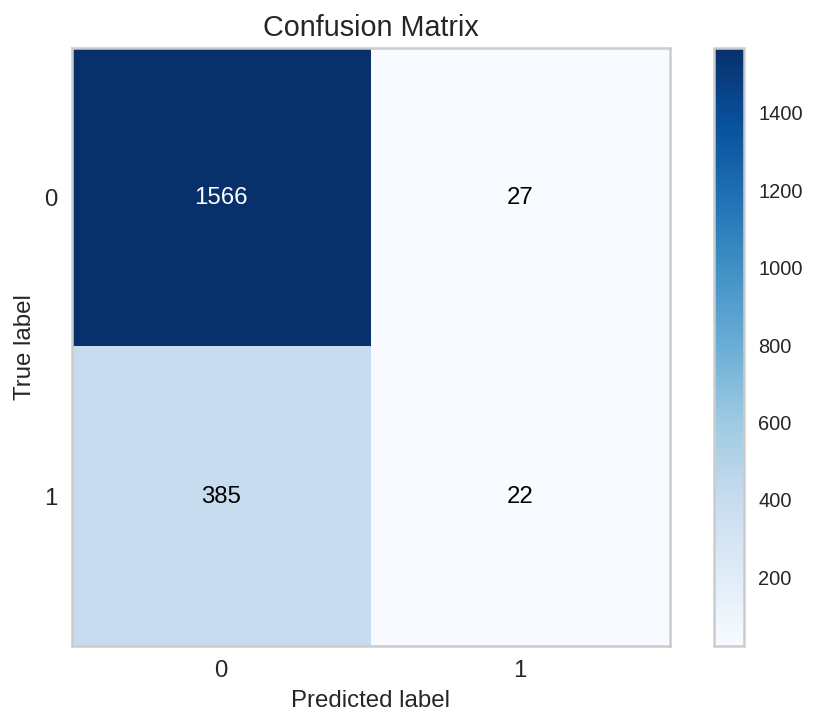

In [ ]:
# Logistic Regression result
skplt.metrics.plot_confusion_matrix(y_test, lr_pred);

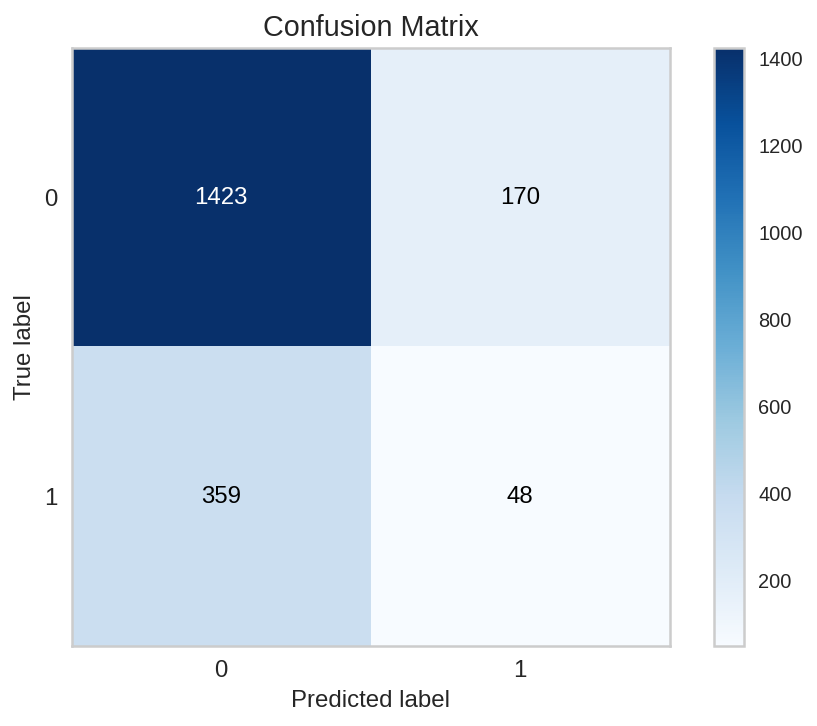

In [ ]:
# KNN result
skplt.metrics.plot_confusion_matrix(y_test, knn_pred);

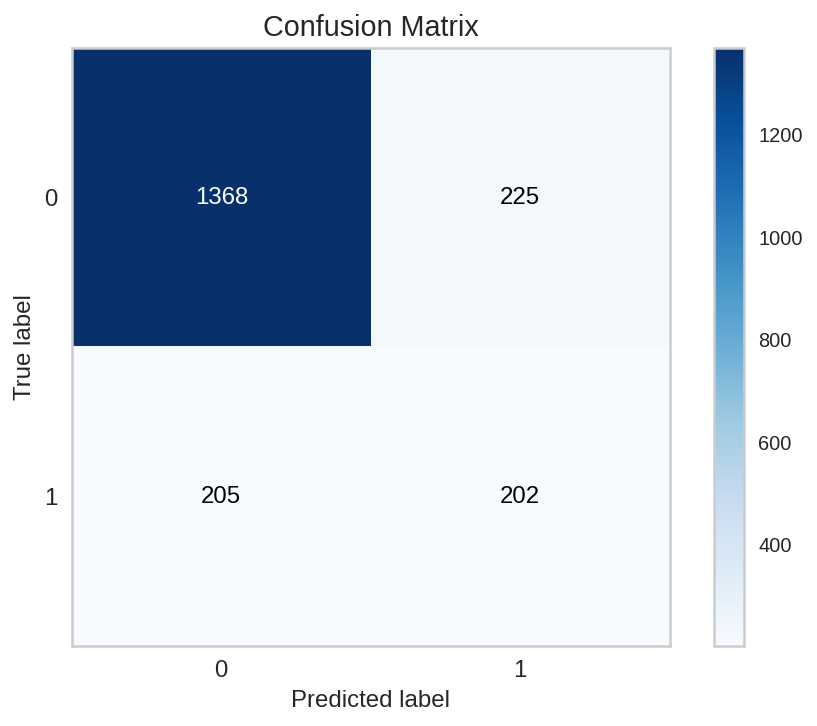

In [ ]:
# Decision Tree result
skplt.metrics.plot_confusion_matrix(y_test, dtree_pred);

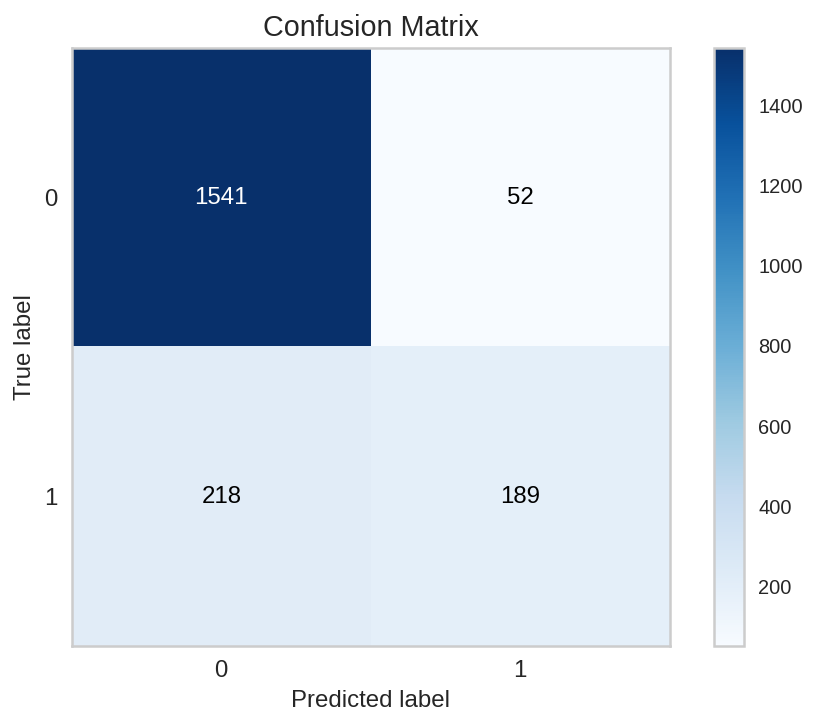

In [ ]:
# random forest result
skplt.metrics.plot_confusion_matrix(y_test, rf_pred);

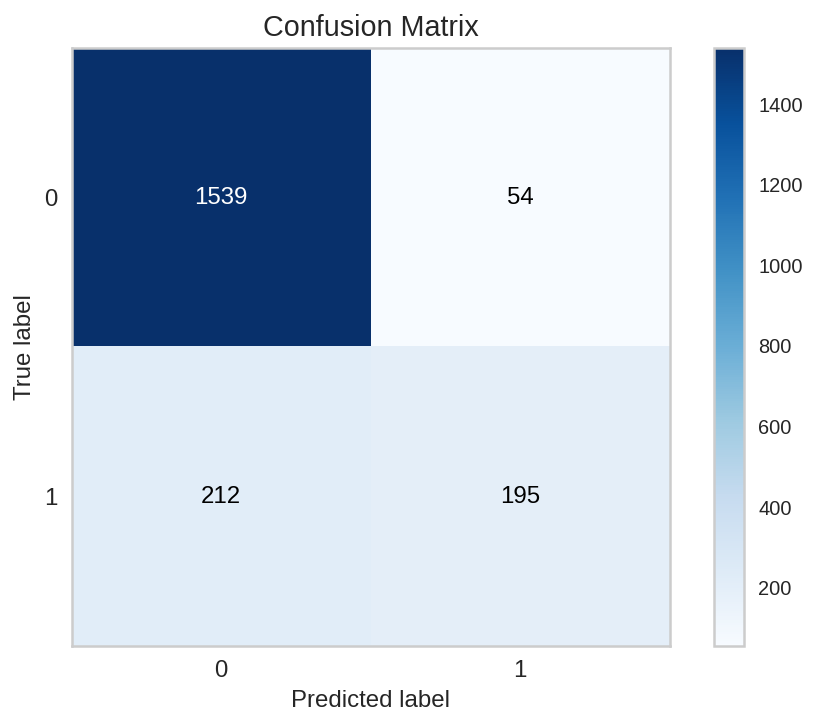

In [ ]:
# xgboost result
skplt.metrics.plot_confusion_matrix(y_test, xgb_pred);

### ROC-AUC

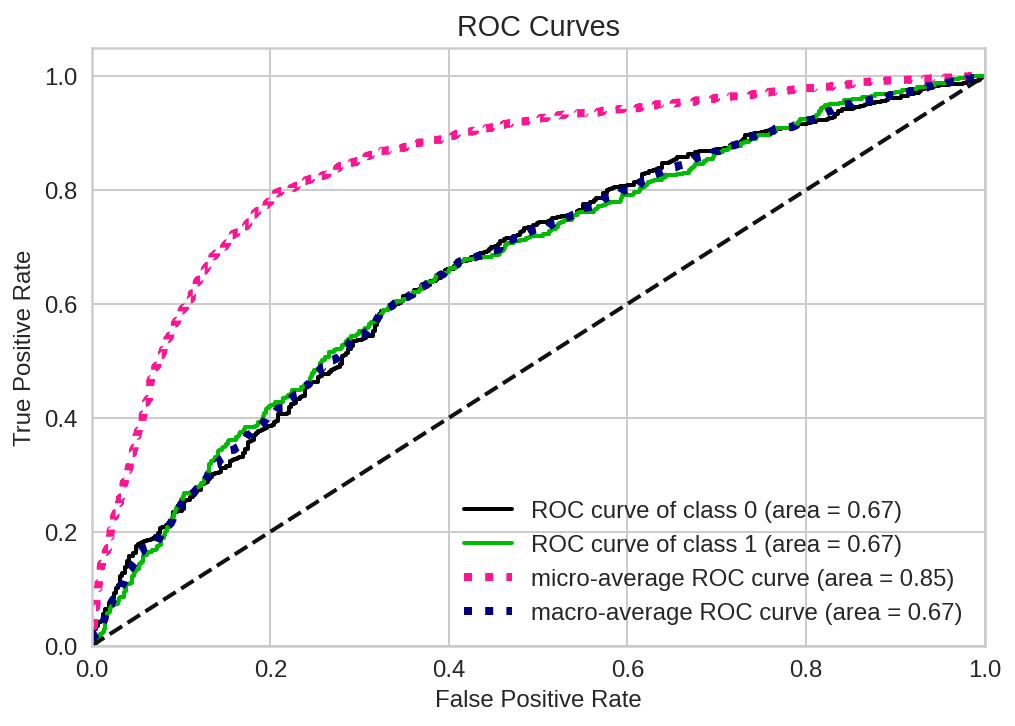

In [ ]:
# Log result
skplt.metrics.plot_roc_curve(y_test, lr_pred_proba);

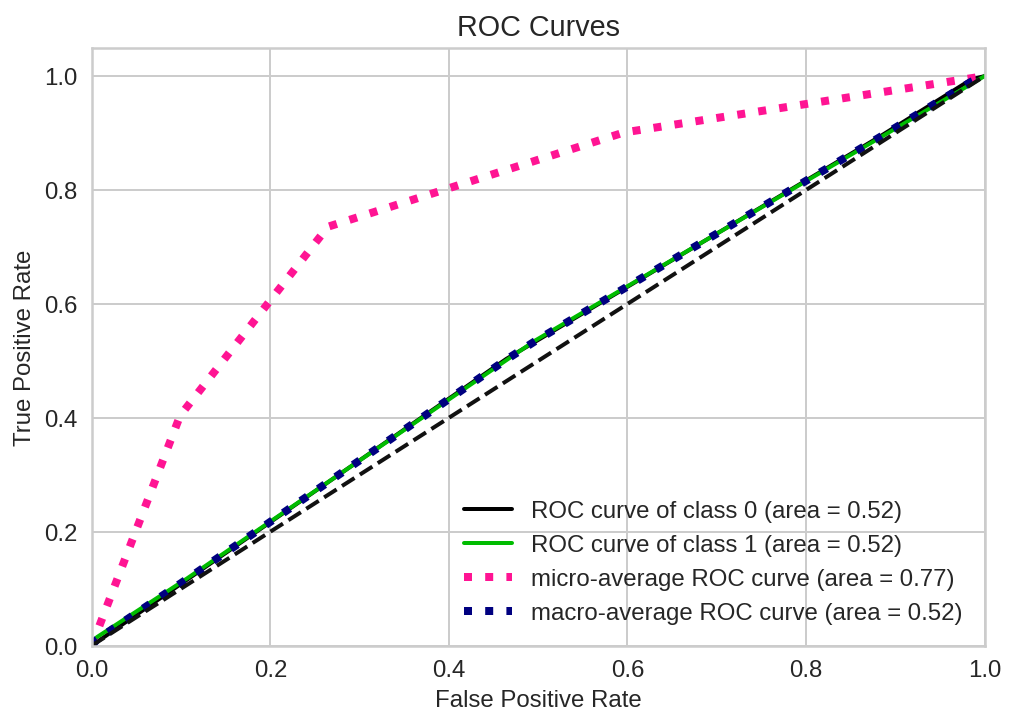

In [ ]:
# KNN result
skplt.metrics.plot_roc_curve(y_test, knn_pred_proba);

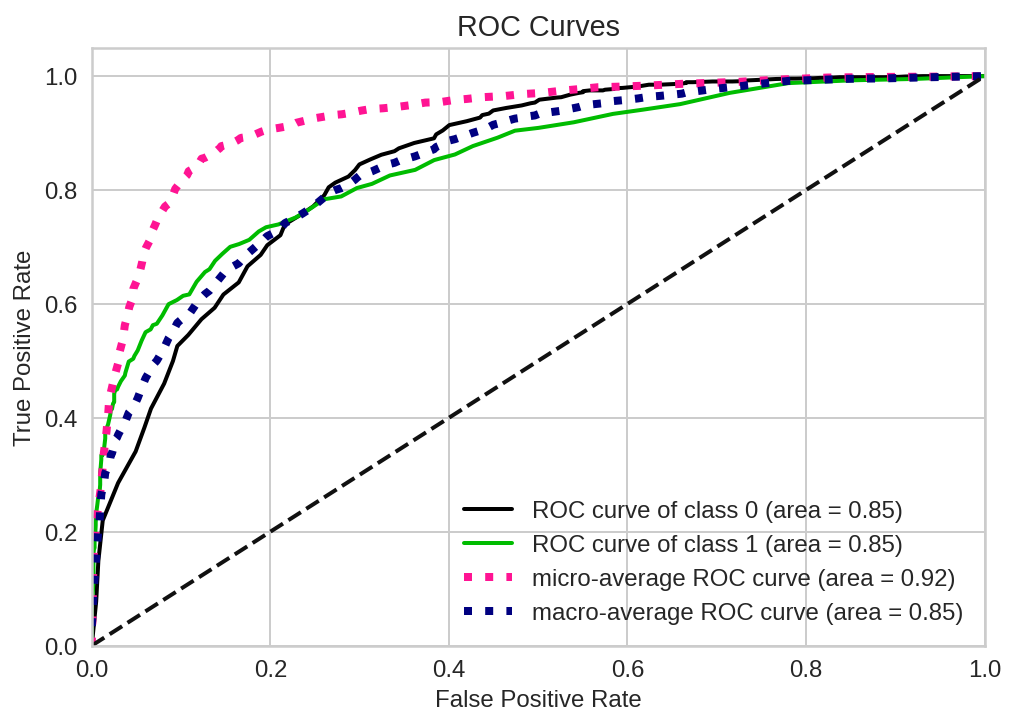

In [ ]:
# random forest result
skplt.metrics.plot_roc_curve(y_test, rf_pred_proba);

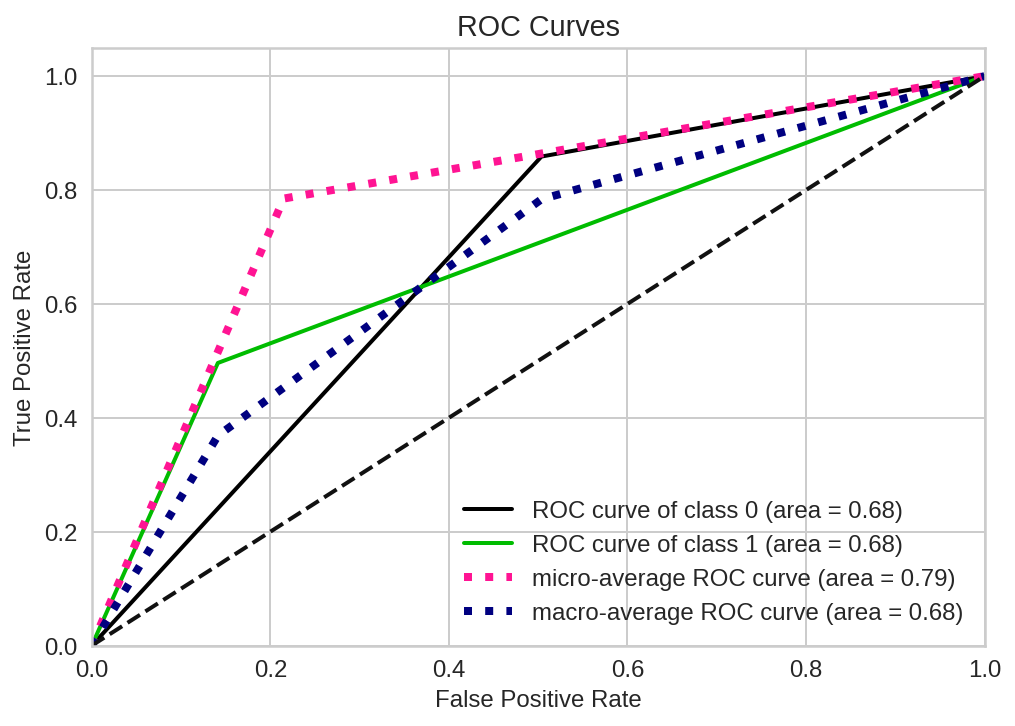

In [ ]:
# Decision Tree perceptron result
skplt.metrics.plot_roc_curve(y_test, dtree_pred_proba);

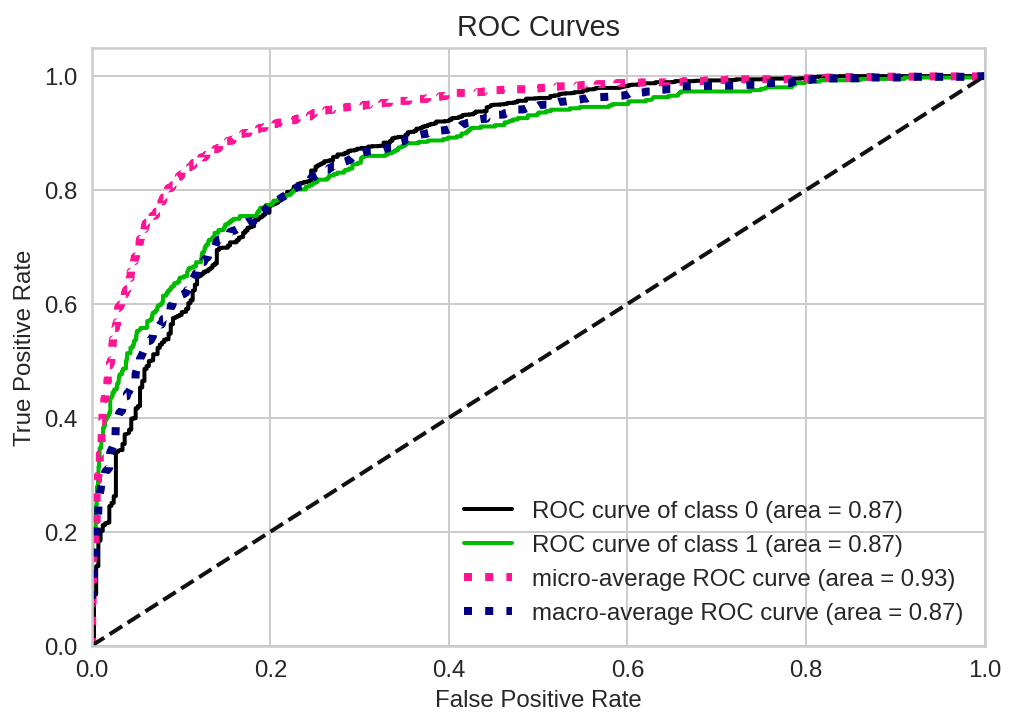

In [ ]:
# XGBoost perceptron result
skplt.metrics.plot_roc_curve(y_test, xgb_pred_proba);

### AOC Score

In [ ]:
# check LogReg f1-score
metrics.roc_auc_score(y_test, lr_pred)

0.5185524507558406

In [ ]:
# check KNN f1-score
metrics.roc_auc_score(y_test, knn_pred)

0.5056096157791073

In [ ]:
# check Decision Tree f1-score
metrics.roc_auc_score(y_test, dtree_pred)

0.6775357792306945

In [ ]:
# check Random Forest f1-score
metrics.roc_auc_score(y_test, rf_pred)

0.7158653260348176

In [ ]:
# check XGBoost f1-score
metrics.roc_auc_score(y_test, xgb_pred)

0.7226085870153666

### Precision

In [ ]:
# check LogReg f1-score
metrics.precision_score(y_test, lr_pred)

0.4489795918367347

In [ ]:
# check KNN f1-score
metrics.precision_score(y_test, knn_pred)

0.22018348623853212

In [ ]:
# check Decision Tree f1-score
metrics.precision_score(y_test, dtree_pred)

0.47306791569086654

In [ ]:
# check Random Forest f1-score
metrics.precision_score(y_test, rf_pred)

0.7842323651452282

In [ ]:
# check XGBoost f1-score
metrics.precision_score(y_test, xgb_pred)

0.7831325301204819

### Recall

In [ ]:
# check LogReg f1-score
metrics.recall_score(y_test, lr_pred)

0.05405405405405406

In [ ]:
# check KNN f1-score
metrics.recall_score(y_test, knn_pred)

0.11793611793611794

In [ ]:
# check Decision Tree f1-score
metrics.recall_score(y_test, dtree_pred)

0.4963144963144963

In [ ]:
# check Random Forest f1-score
metrics.recall_score(y_test, rf_pred)

0.4643734643734644

In [ ]:
# check XGBoost f1-score
metrics.recall_score(y_test, xgb_pred)

0.47911547911547914

### F1-Score

In [ ]:
# check LogReg f1-score
metrics.f1_score(y_test, lr_pred)

0.09649122807017545

In [ ]:
# check KNN f1-score
metrics.f1_score(y_test, knn_pred)

0.15360000000000001

In [ ]:
# check Decision Tree f1-score
metrics.f1_score(y_test, dtree_pred)

0.4844124700239808

In [ ]:
# check Random Forest f1-score
metrics.f1_score(y_test, rf_pred)

0.5833333333333334

In [ ]:
# check XGBoost f1-score
metrics.f1_score(y_test, xgb_pred)

0.5945121951219512

# Imbalanced Modelling using G-Means

## Logistic Regression

In [ ]:
# find fpr and tpr using roc_curve() method
fpr, tpr, thresholds = metrics.roc_curve(y_test, lr_pred_proba[:,1])

# calculate g-means
gmeans = np.sqrt(tpr * (1-fpr))

# find the best threshold
ix = np.argmax(gmeans)

print('Best Threshold={}, G-Mean={}'.format(thresholds[ix], gmeans[ix]))

Best Threshold=0.2067747188734616, G-Mean=0.6322477199628294


### New Prediction

In [ ]:
# change predict proba result to optimized one using new threshold
new_pred_result = (lr_pred_proba[:,1] >= thresholds[ix]).astype(int)

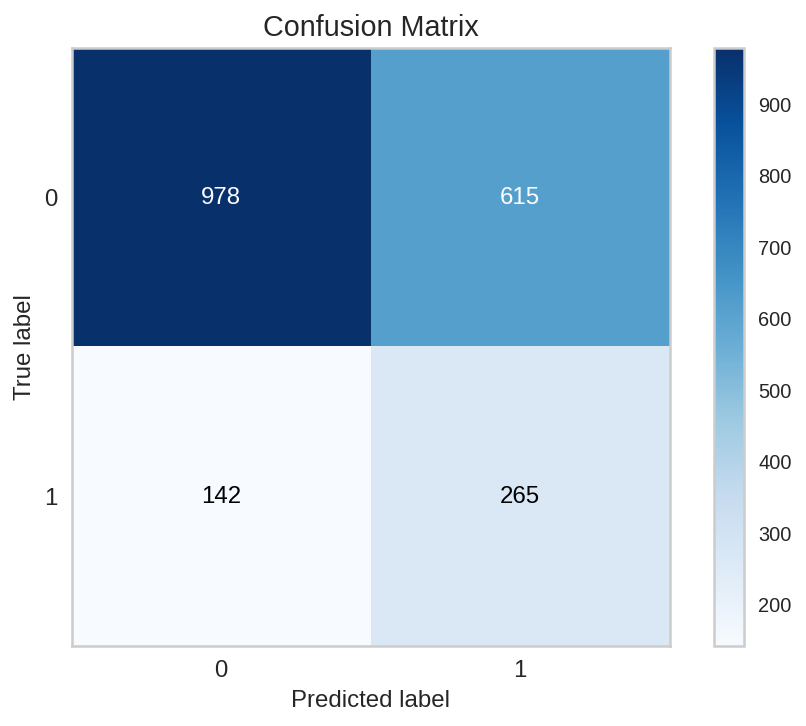

In [ ]:
# visualize confusion matrix after setting new threshold
skplt.metrics.plot_confusion_matrix(y_test, new_pred_result);

In [ ]:
# check new ROC-AUC
metrics.roc_auc_score(y_test, new_pred_result)

0.6325208104869121

In [ ]:
# check new precision
metrics.precision_score(y_test, new_pred_result)

0.30113636363636365

In [ ]:
# check new recall
metrics.recall_score(y_test, new_pred_result)

0.6511056511056511

In [ ]:
# check new f1-score
metrics.f1_score(y_test, new_pred_result)

0.41181041181041184

In [ ]:
# check classification report result of new prediction result
pd.DataFrame(metrics.classification_report(y_test, new_pred_result, target_names=['0','1'], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.873214,0.301136,0.6215,0.587175,0.756796
recall,0.613936,0.651106,0.6215,0.632521,0.621500
f1-score,0.720973,0.411810,0.6215,0.566392,0.658058
support,1593.000000,407.000000,0.6215,2000.000000,2000.000000


### Old Prediction

In [ ]:
# check old ROC-AUC
metrics.roc_auc_score(y_test, lr_pred)

0.5185524507558406

In [ ]:
# check old precision
metrics.precision_score(y_test, lr_pred)

0.4489795918367347

In [ ]:
# check old recall
metrics.recall_score(y_test, lr_pred)

0.05405405405405406

In [ ]:
# compare to the old f1 score
metrics.f1_score(y_test, lr_pred)

0.09649122807017545

In [ ]:
# check classification report result of previous prediction result
pd.DataFrame(metrics.classification_report(y_test, lr_pred, target_names=['0','1'], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.802665,0.448980,0.794,0.625822,0.730690
recall,0.983051,0.054054,0.794,0.518552,0.794000
f1-score,0.883747,0.096491,0.794,0.490119,0.723541
support,1593.000000,407.000000,0.794,2000.000000,2000.000000


## K-Nearest Neighbors

In [ ]:
# find fpr and tpr using roc_curve() method
fpr, tpr, thresholds = metrics.roc_curve(y_test, knn_pred_proba[:,1])

# calculate g-means
gmeans = np.sqrt(tpr * (1-fpr))

# find the best threshold
ix = np.argmax(gmeans)

print('Best Threshold={}, G-Mean={}'.format(thresholds[ix], gmeans[ix]))

Best Threshold=0.3333333333333333, G-Mean=0.5192904531640462


### New Prediction

In [ ]:
# change predict proba result to optimized one using new threshold
new_pred_result = (knn_pred_proba[:,1] >= thresholds[ix]).astype(int)

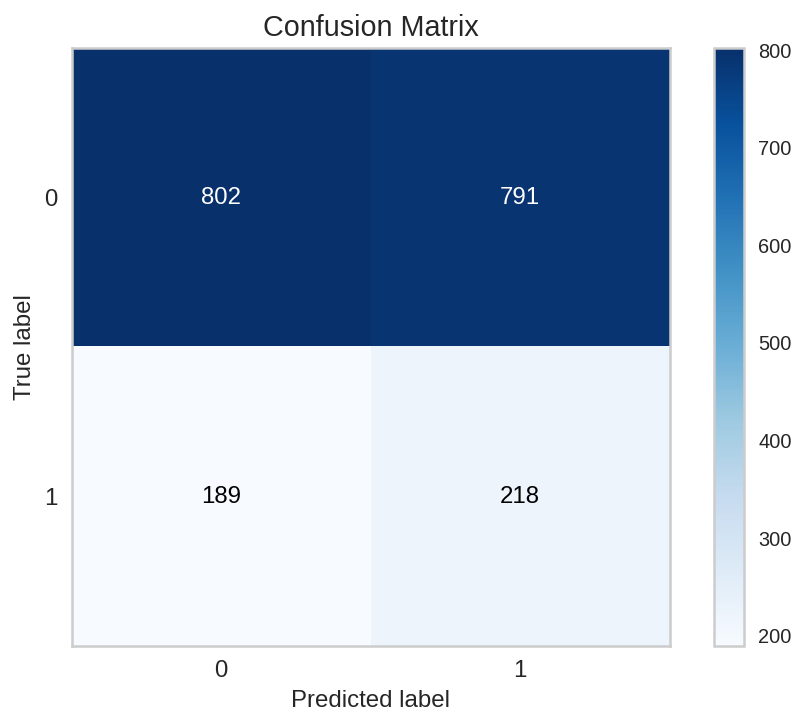

In [ ]:
# visualize confusion matrix after setting new threshold
skplt.metrics.plot_confusion_matrix(y_test, new_pred_result);

In [ ]:
# check new ROC-AUC
metrics.roc_auc_score(y_test, new_pred_result)

0.519539570387028

In [ ]:
# check new precision
metrics.precision_score(y_test, new_pred_result)

0.21605550049554015

In [ ]:
# check new recall
metrics.recall_score(y_test, new_pred_result)

0.5356265356265356

In [ ]:
# check new f1-score
metrics.f1_score(y_test, new_pred_result)

0.307909604519774

In [ ]:
# check classification report result of new prediction result
pd.DataFrame(metrics.classification_report(y_test, new_pred_result, target_names=['0','1'], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.809284,0.216056,0.51,0.512670,0.688562
recall,0.503453,0.535627,0.51,0.519540,0.510000
f1-score,0.620743,0.307910,0.51,0.464326,0.557081
support,1593.000000,407.000000,0.51,2000.000000,2000.000000


### Old Prediction

In [ ]:
# check old ROC-AUC
metrics.roc_auc_score(y_test, lr_pred)

0.5185524507558406

In [ ]:
# check old precision
metrics.precision_score(y_test, knn_pred)

0.22018348623853212

In [ ]:
# check old recall
metrics.recall_score(y_test, knn_pred)

0.11793611793611794

In [ ]:
# compare to the old f1 score
metrics.f1_score(y_test, knn_pred)

0.15360000000000001

In [ ]:
# check classification report result of previous prediction result
pd.DataFrame(metrics.classification_report(y_test, knn_pred, target_names=['0','1'], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.798541,0.220183,0.7355,0.509362,0.680845
recall,0.893283,0.117936,0.7355,0.505610,0.735500
f1-score,0.843259,0.153600,0.7355,0.498430,0.702914
support,1593.000000,407.000000,0.7355,2000.000000,2000.000000


## Decision Tree

In [ ]:
# find fpr and tpr using roc_curve() method
fpr, tpr, thresholds = metrics.roc_curve(y_test, dtree_pred_proba[:,1])

# calculate g-means
gmeans = np.sqrt(tpr * (1-fpr))

# find the best threshold
ix = np.argmax(gmeans)

print('Best Threshold={}, G-Mean={}'.format(thresholds[ix], gmeans[ix]))

Best Threshold=1.0, G-Mean=0.6528503494338895


In [ ]:
# change predict proba result to optimized one using new threshold
new_pred_result = (dtree_pred_proba[:,1] >= thresholds[ix]).astype(int)

### New Prediction

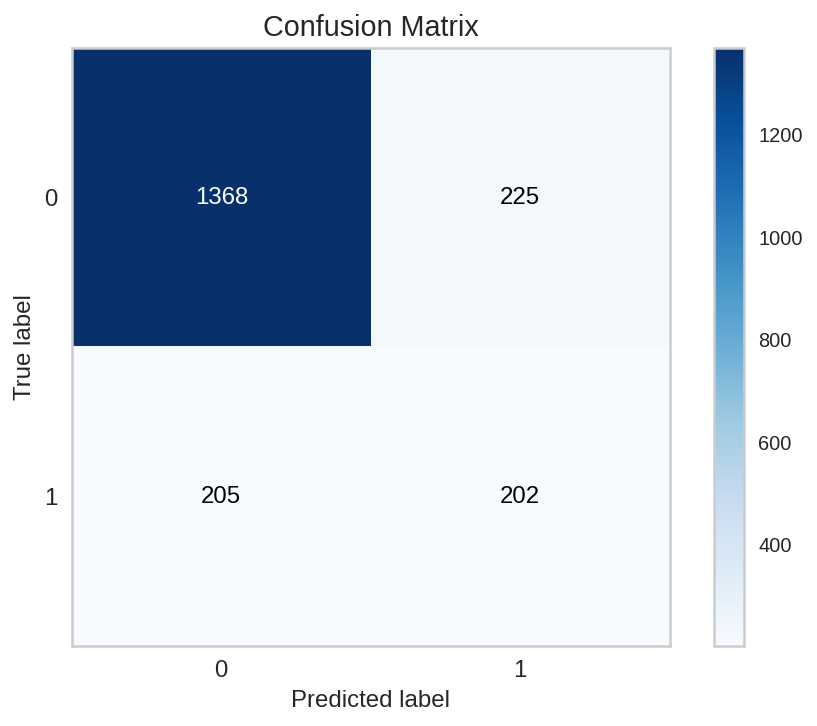

In [ ]:
# visualize confusion matrix after setting new threshold
skplt.metrics.plot_confusion_matrix(y_test, new_pred_result);

In [ ]:
# check new ROC-AUC
metrics.roc_auc_score(y_test, new_pred_result)

0.6775357792306945

In [ ]:
# check new precision
metrics.precision_score(y_test, new_pred_result)

0.47306791569086654

In [ ]:
# check new recall
metrics.recall_score(y_test, new_pred_result)

0.4963144963144963

In [ ]:
# check new f1-score
metrics.f1_score(y_test, new_pred_result)

0.4844124700239808

In [ ]:
# check classification report result of new prediction result
pd.DataFrame(metrics.classification_report(y_test, new_pred_result, target_names=['0','1'], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.869676,0.473068,0.785,0.671372,0.788966
recall,0.858757,0.496314,0.785,0.677536,0.785000
f1-score,0.864182,0.484412,0.785,0.674297,0.786899
support,1593.000000,407.000000,0.785,2000.000000,2000.000000


### Old Prediction

In [ ]:
# check old f1-score
metrics.roc_auc_score(y_test, dtree_pred)

0.6775357792306945

In [ ]:
# check old precision
metrics.precision_score(y_test, dtree_pred)

0.47306791569086654

In [ ]:
# check old recall
metrics.recall_score(y_test, dtree_pred)

0.4963144963144963

In [ ]:
# compare to the old f1 score
metrics.f1_score(y_test, dtree_pred)

0.4844124700239808

In [ ]:
# check classification report result of previous prediction result
pd.DataFrame(metrics.classification_report(y_test, dtree_pred, target_names=['0','1'], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.869676,0.473068,0.785,0.671372,0.788966
recall,0.858757,0.496314,0.785,0.677536,0.785000
f1-score,0.864182,0.484412,0.785,0.674297,0.786899
support,1593.000000,407.000000,0.785,2000.000000,2000.000000


## Random Forest

In [ ]:
# find fpr and tpr using roc_curve() method
fpr, tpr, thresholds = metrics.roc_curve(y_test, rf_pred_proba[:,1])

# calculate g-means
gmeans = np.sqrt(tpr * (1-fpr))

# find the best threshold
ix = np.argmax(gmeans)

print('Best Threshold={}, G-Mean={}'.format(thresholds[ix], gmeans[ix]))

Best Threshold=0.28, G-Mean=0.7692010482878984


In [ ]:
# change predict proba result to optimized one using new threshold
new_pred_result = (rf_pred_proba[:,1] >= thresholds[ix]).astype(int)

### New Prediction

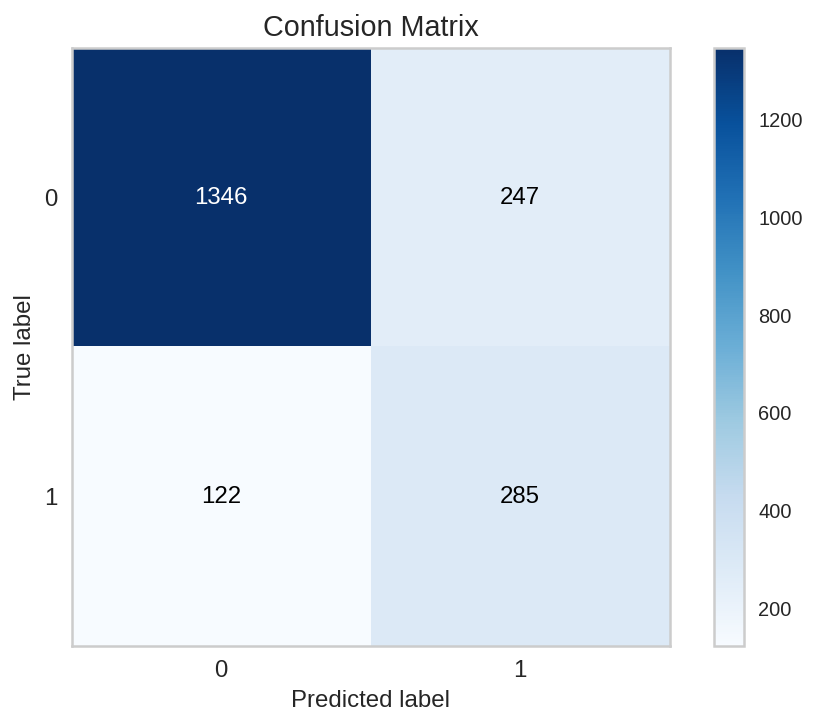

In [ ]:
# visualize confusion matrix after setting new threshold
skplt.metrics.plot_confusion_matrix(y_test, new_pred_result);

In [ ]:
# check new ROC-AUC
metrics.roc_auc_score(y_test, new_pred_result)

0.7725961709012555

In [ ]:
# check new precision
metrics.precision_score(y_test, new_pred_result)

0.5357142857142857

In [ ]:
# check new recall
metrics.recall_score(y_test, new_pred_result)

0.7002457002457002

In [ ]:
# check new f1-score
metrics.f1_score(y_test, new_pred_result)

0.6070287539936102

In [ ]:
# check classification report result of new prediction result
pd.DataFrame(metrics.classification_report(y_test, new_pred_result, target_names=['0','1'], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.916894,0.535714,0.8155,0.726304,0.839324
recall,0.844947,0.700246,0.8155,0.772596,0.815500
f1-score,0.879451,0.607029,0.8155,0.743240,0.824013
support,1593.000000,407.000000,0.8155,2000.000000,2000.000000


### Old Prediction

In [ ]:
# check old ROC-AUC
metrics.roc_auc_score(y_test, rf_pred)

0.7158653260348176

In [ ]:
# check old precision
metrics.precision_score(y_test, rf_pred)

0.7842323651452282

In [ ]:
# check old recall
metrics.recall_score(y_test, rf_pred)

0.4643734643734644

In [ ]:
# compare to the old f1 score
metrics.f1_score(y_test, rf_pred)

0.5833333333333334

In [ ]:
# check classification report result of previous prediction result
pd.DataFrame(metrics.classification_report(y_test, rf_pred, target_names=['0','1'], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.876066,0.784232,0.865,0.830149,0.857378
recall,0.967357,0.464373,0.865,0.715865,0.865000
f1-score,0.919451,0.583333,0.865,0.751392,0.851051
support,1593.000000,407.000000,0.865,2000.000000,2000.000000


## XGBoost

In [ ]:
# find fpr and tpr using roc_curve() method
fpr, tpr, thresholds = metrics.roc_curve(y_test, xgb_pred_proba[:,1])

# calculate g-means
gmeans = np.sqrt(tpr * (1-fpr))

# find the best threshold
ix = np.argmax(gmeans)

print('Best Threshold={}, G-Mean={}'.format(thresholds[ix], gmeans[ix]))

Best Threshold=0.22570465505123138, G-Mean=0.793957446579221


In [ ]:
# change predict proba result to optimized one using new threshold
new_pred_result = (xgb_pred_proba[:,1] >= thresholds[ix]).astype(int)

### New Prediction

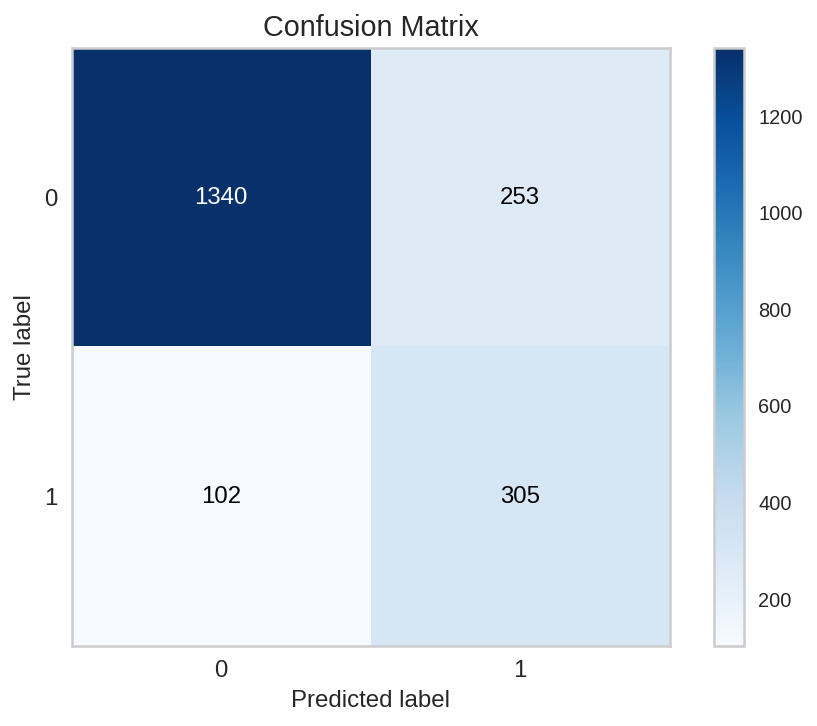

In [ ]:
# visualize confusion matrix after setting new threshold
skplt.metrics.plot_confusion_matrix(y_test, new_pred_result);

In [ ]:
# check new ROC-AUC
metrics.roc_auc_score(y_test, new_pred_result)

0.7952829562999054

In [ ]:
# check new precision
metrics.precision_score(y_test, new_pred_result)

0.546594982078853

In [ ]:
# check new recall
metrics.recall_score(y_test, new_pred_result)

0.7493857493857494

In [ ]:
# check new f1-score
metrics.f1_score(y_test, new_pred_result)

0.6321243523316062

In [ ]:
# check classification report result of new prediction result
pd.DataFrame(metrics.classification_report(y_test, new_pred_result, target_names=['0','1'], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.929265,0.546595,0.8225,0.737930,0.851392
recall,0.841180,0.749386,0.8225,0.795283,0.822500
f1-score,0.883031,0.632124,0.8225,0.757578,0.831972
support,1593.000000,407.000000,0.8225,2000.000000,2000.000000


### Old Prediction

In [ ]:
# check old ROC-AUC
metrics.roc_auc_score(y_test, xgb_pred)

0.7226085870153666

In [ ]:
# check old precision
metrics.precision_score(y_test, xgb_pred)

0.7831325301204819

In [ ]:
# check old recall
metrics.recall_score(y_test, xgb_pred)

0.47911547911547914

In [ ]:
# compare to the old f1 score
metrics.f1_score(y_test, xgb_pred)

0.5945121951219512

In [ ]:
# check classification report result of previous prediction result
pd.DataFrame(metrics.classification_report(y_test, xgb_pred, target_names=['0','1'], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.878926,0.783133,0.867,0.831029,0.859432
recall,0.966102,0.479115,0.867,0.722609,0.867000
f1-score,0.920455,0.594512,0.867,0.757483,0.854125
support,1593.000000,407.000000,0.867,2000.000000,2000.000000


# Model Agnostics

### Variable Importance - Partial Dependence Plot

In [ ]:
## initiate explainer for LogReg model
churn_exp = dx.Explainer(xgb, X_train, y_train, label = "XGBoost Interpretation")

Preparation of a new explainer is initiated

  -> data              : 8000 rows 10 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 8000 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : XGBoost Interpretation
  -> predict function  : <function yhat_proba_default at 0x7feb186569e0> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.00552, mean = 0.204, max = 0.997
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.957, mean = 3.61e-05, max = 0.987
  -> model_info        : package xgboost

A new explainer has been created!


In [ ]:
# visualize permutation feature importance for XGBoost model
churn_exp.model_parts().plot()

In [ ]:
# create partial dependence plot of XGBoost model
churn_exp.model_profile().plot()

Calculating ceteris paribus: 100%|██████████| 10/10 [00:00<00:00, 28.23it/s]


# Business Evaluation Metrics

### Gain Cumulative Curve

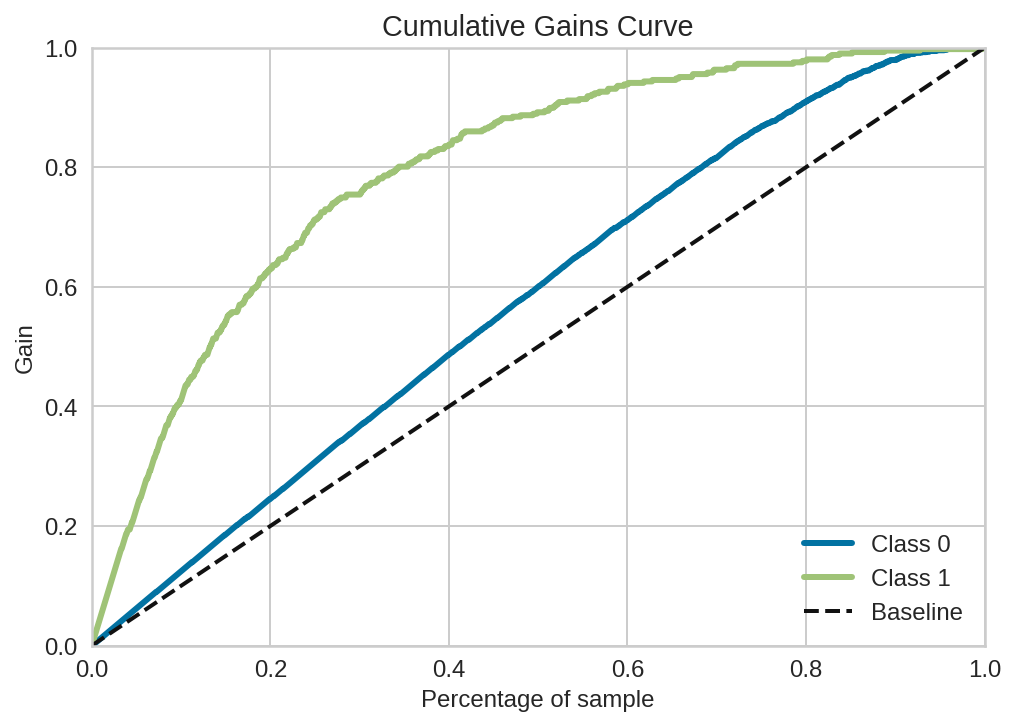

In [ ]:
skplt.metrics.plot_cumulative_gain(y_test, xgb_pred_proba)

### Lift Curve

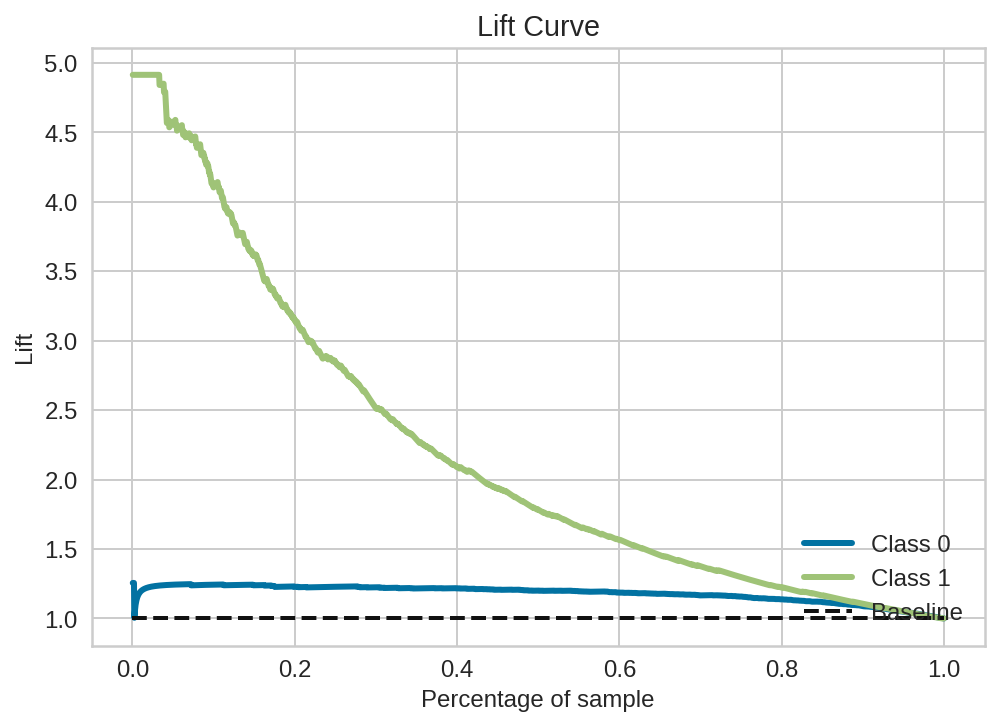

In [ ]:
skplt.metrics.plot_lift_curve(y_test, xgb_pred_proba)

### Profit Curve

In [ ]:
def standard_confusion_matrix(y_true, y_pred):
    '''
    Reformat confusion matrix output from sklearn for plotting profit curve.
    '''
    [[tn, fp], [fn, tp]] = metrics.confusion_matrix(y_true, y_pred)
    return np.array([[tp, fp], [fn, tn]])

def plot_profit_curve(model_object, costbenefit_mat, y_proba, y_test):
    '''
    Plot profit curve.

    INPUTS:
    - model object
    - cost benefit matrix in the same format as the confusion matrix above
    - predicted probabilities
    - actual labels
    '''

    # Profit curve data
    profits = [] # one profit value for each T (threshold)
    thresholds = sorted(y_proba, reverse=True)

    # For each threshold, calculate profit - starting with largest threshold
    for T in thresholds:
        y_pred = (y_proba > T).astype(int)
        confusion_mat = metrics.confusion_matrix(y_test, y_pred)
        # Calculate total profit for this threshold
        profit = sum(sum(confusion_mat * costbenefit_mat)) / len(y_test)
        profits.append(profit)

    print(profits)
    # Profit curve plot
    model_name = model_object.__class__.__name__
    max_profit = max(profits)
    plt.plot(np.linspace(0, 1, len(y_test)), profits, label = '{}, max profit ${:.2f} per user'.format(model_name, max_profit))


In [ ]:
# create cost benefit matrix
costbenefit_mat = np.array([[0, -10000],
                            [0, 30000 - 10000]])

In [ ]:
# check cost benefit matrix
costbenefit_mat

array([[     0, -10000],
       [     0,  20000]])

In [ ]:
# check model confusion matrix
metrics.confusion_matrix(y_test, xgb_pred)

array([[1539,   54],
       [ 212,  195]])

In [ ]:
# XGBoost
xgb = XGBClassifier()

# xgb_params
xgb_params = {
    'n_estimators': [10, 50, 100],
    'max_depth': [3,5,10,'None'],
    'learning_rate': [0.1, 0.05, 0.01],
    'grow_policy': ['depthwise', 'lossguide']
}

# define model with GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb, 
    param_grid=xgb_params, 
    n_jobs=1, 
    verbose=1,
    cv = 5,
    scoring = "f1"
)

# fitting gridsearch
grid_search.fit(X_train, y_train)

# check the best estimator
grid_search.best_estimator_

Fitting 5 folds for each of 72 candidates, totalling 360 fits


XGBClassifier(grow_policy='depthwise', max_depth=5)

In [ ]:
# assign the best estimator to new variable
tree_best = grid_search.best_estimator_

[0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0, 110.0, 120.0, 130.0, 140.0, 150.0, 160.0, 170.0, 180.0, 190.0, 200.0, 210.0, 220.0, 230.0, 240.0, 250.0, 260.0, 270.0, 280.0, 290.0, 300.0, 310.0, 320.0, 330.0, 340.0, 350.0, 360.0, 370.0, 380.0, 390.0, 400.0, 410.0, 420.0, 430.0, 440.0, 450.0, 460.0, 470.0, 480.0, 490.0, 500.0, 510.0, 520.0, 530.0, 540.0, 550.0, 560.0, 570.0, 580.0, 590.0, 600.0, 610.0, 620.0, 630.0, 640.0, 650.0, 660.0, 655.0, 665.0, 675.0, 685.0, 695.0, 705.0, 715.0, 725.0, 735.0, 745.0, 755.0, 750.0, 760.0, 770.0, 780.0, 775.0, 770.0, 765.0, 760.0, 770.0, 780.0, 790.0, 800.0, 810.0, 805.0, 815.0, 825.0, 835.0, 845.0, 855.0, 865.0, 875.0, 885.0, 895.0, 905.0, 915.0, 925.0, 935.0, 945.0, 955.0, 950.0, 960.0, 970.0, 965.0, 975.0, 985.0, 995.0, 1005.0, 1015.0, 1025.0, 1035.0, 1045.0, 1055.0, 1065.0, 1075.0, 1085.0, 1080.0, 1090.0, 1085.0, 1095.0, 1105.0, 1115.0, 1125.0, 1135.0, 1130.0, 1140.0, 1150.0, 1160.0, 1170.0, 1180.0, 1190.0, 1200.0, 1210.0, 1220

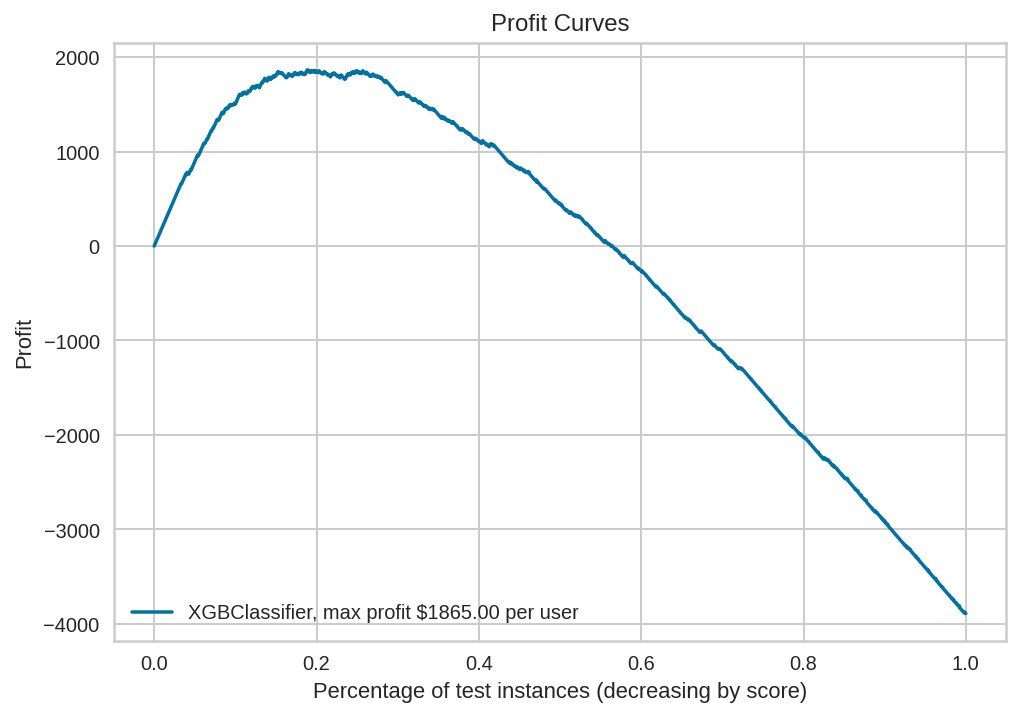

In [ ]:
plot_profit_curve(tree_best,costbenefit_mat, xgb_pred_proba[:,1], y_test)
plt.xlabel('Percentage of test instances (decreasing by score)')
plt.ylabel('Profit')
plt.title('Profit Curves')
plt.legend(loc='lower left')
plt.show()